# Dog Breed Identification
Determine the breed of a dog in an image

### Dataset
This data is part of Kaggle Playground Prediction Competition of 2017.

In this playground competition, the candidates were provided with a strictly canine subset of ImageNet in order to practice fine-grained image categorization. The dataset had 120 breeds of dogs and a limited number training images per class. Each image has a filename that is its unique id. The dataset comprises 120 breeds of dogs. The goal of the competition is to create a classifier capable of determining a dog's breed from a photo.

### File descriptions
- train.zip - the training set, you are provided the breed for these dogs
- test.zip - the test set, you must predict the probability of each breed for each image
- sample_submission.csv - a sample submission file in the correct format
- labels.csv - the breeds for the images in the train set

### Acknowledgments

Kaggle authorities extend their gratitude to the creators of the Stanford Dogs Dataset, which made this competition possible: Aditya Khosla, Nityananda Jayadevaprakash, Bangpeng Yao, and Fei-Fei Li.

In [1]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

In [2]:
!cat /proc/meminfo

MemTotal:       13333568 kB
MemFree:         9274484 kB
MemAvailable:   12374908 kB
Buffers:           57872 kB
Cached:          3176692 kB
SwapCached:            0 kB
Active:          2333020 kB
Inactive:        1404468 kB
Active(anon):     462316 kB
Inactive(anon):      364 kB
Active(file):    1870704 kB
Inactive(file):  1404104 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               528 kB
Writeback:             0 kB
AnonPages:        503048 kB
Mapped:           213252 kB
Shmem:              1056 kB
Slab:             180116 kB
SReclaimable:     133604 kB
SUnreclaim:        46512 kB
KernelStack:        5044 kB
PageTables:         7048 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6666784 kB
Committed_AS:    3583472 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
Percpu:             1040 kB
AnonHugePages:   

In [3]:
#GPU count and name
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-ba501f72-9d28-0a91-ca82-d51db85f1ce4)


In [4]:
!nvidia-smi

Tue Mar  9 16:13:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import tensorflow as tf
print (tf.__version__)

2.4.1


In [6]:
tf.keras.backend.clear_session()

In [7]:
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.layers import ZeroPadding2D
from pandas_profiling import ProfileReport

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import cv2
import tensorflow_hub as hub
import functools

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
project_path = '/content/drive/My Drive/DogBreed_Classification/'

In [10]:
from zipfile import ZipFile
with ZipFile(project_path+'train.zip','r') as z:
  z.extractall()

In [11]:
from zipfile import ZipFile
with ZipFile(project_path+'test.zip','r') as z:
  z.extractall()

In [12]:
submission = pd.read_csv(project_path+'sample_submission.csv.zip')
test_img = submission['id']
submission.head()

id  ...  yorkshire_terrier
0  000621fb3cbb32d8935728e48679680e  ...           0.008333
1  00102ee9d8eb90812350685311fe5890  ...           0.008333
2  0012a730dfa437f5f3613fb75efcd4ce  ...           0.008333
3  001510bc8570bbeee98c8d80c8a95ec1  ...           0.008333
4  001a5f3114548acdefa3d4da05474c2e  ...           0.008333

[5 rows x 121 columns]

In [13]:
labels = pd.read_csv(project_path+'labels.csv.zip')
labels.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [14]:
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('dogbreed_cnn.h5', #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max',
                                                    min_delta=0.001,
                                                    patience=5,
                                                    verbose=1)
model_es=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',min_delta=0.001,patience=5,mode='max',verbose=1)
model_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.01,patience=5,verbose=1,mode='auto',min_delta=0.0001)

In [15]:
top5_acc = functools.partial(tf.keras.metrics.top_k_categorical_accuracy, k=5)
top5_acc.__name__ = 'top5_acc'

In [16]:
#!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [17]:
profile = ProfileReport(labels,title='Dog Breeds Profiling', explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/15 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
profile.to_file("Dog Breeds Profile Report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
breed_count=labels['breed'].value_counts()
breed_count.head()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: breed, dtype: int64

In [20]:
#targets = pd.Series(labels['breed'])
#one_hot = pd.get_dummies(targets)
#one_hot_labels = np.asarray(one_hot)

In [21]:
IMG_SIZE=128
channels=1
EPOCHS=20
BATCH=32

In [22]:
x_features=[]
label=[]

for f, img in tqdm(labels.values): #f for image id, img for dog breed
  #Using cv2.imread results in BGR images, instead of the standard RGB as below
  train_img = cv2.imread('./train/{}.jpg'.format(f),0) #0 for grayscale & 1 for color (o/p is bgr)
  train_img_resize = cv2.resize(train_img, (IMG_SIZE,IMG_SIZE))
  x_features.append(train_img_resize)
  label.append(img)

100%|██████████| 10222/10222 [00:15<00:00, 654.42it/s]


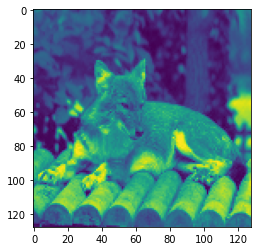

In [23]:
plt.imshow(x_features[42])

In [24]:
x_test_feature=[]
i=0
for f in tqdm(test_img.values):
    img = cv2.imread('./test/{}.jpg'.format(f),0)
    img_resize = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    x_test_feature.append(img_resize)

100%|██████████| 10357/10357 [00:15<00:00, 688.52it/s]


In [25]:
encoder = LabelEncoder()
label = encoder.fit_transform(label)
y_label = tf.keras.utils.to_categorical(label, num_classes=None, dtype='int')#, 120)

In [26]:
x_train_data = np.array(x_features,np.float32)/255.0  #Division by 255. for normalisation
print(x_train_data.shape)
x_train_data = np.expand_dims(x_train_data, axis=3)
print(x_train_data.shape)

y_train_data = np.array(y_label)
print(y_train_data.shape)

(10222, 128, 128)
(10222, 128, 128, 1)
(10222, 120)


In [27]:
x_test_data = np.array(x_test_feature,np.float32) / 255.0  #Division by 255. for normalisation
print(x_test_data.shape)
x_test_data = np.expand_dims(x_test_data, axis=3)
print(x_test_data.shape)

(10357, 128, 128)
(10357, 128, 128, 1)


In [28]:
x_train,x_val,y_train,y_val=train_test_split(x_train_data,y_train_data,test_size=0.2,random_state=42)
print(x_train.shape)
print(x_val.shape)

(8177, 128, 128, 1)
(2045, 128, 128, 1)


## Using a custom CNN Architecture

In [29]:
model1 = Sequential()
model1.add(Conv2D(32,(5,5),activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,channels)))
model1.add(MaxPooling2D(pool_size=3))
#model1.add(Dropout(0.2))
model1.add(Conv2D(filters=64, kernel_size=4, padding='same',activation='relu'))
model1.add(MaxPooling2D(pool_size=2))
#model1.add(Dropout(0.2))
model1.add(Conv2D(128, kernel_size=3, padding='same',activation='relu'))
model1.add(MaxPooling2D(pool_size=2))
#model1.add(Dropout(0.8))
model1.add(Conv2D(128, kernel_size=2, padding='same',activation='relu'))
model1.add(MaxPooling2D(pool_size=2))
#model1.add(Dropout(0.8))
model1.add(Flatten())
#fully connected layer
model1.add(Dense(units=500,activation='relu'))
model1.add(Dropout(0.2))
#output layer
model1.add(Dense(units=120,activation='softmax'))

In [30]:
optimizer=Adam(lr=0.01)
model1.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy',top5_acc])
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 32)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 41, 41, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 41, 41, 64)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 128)       6

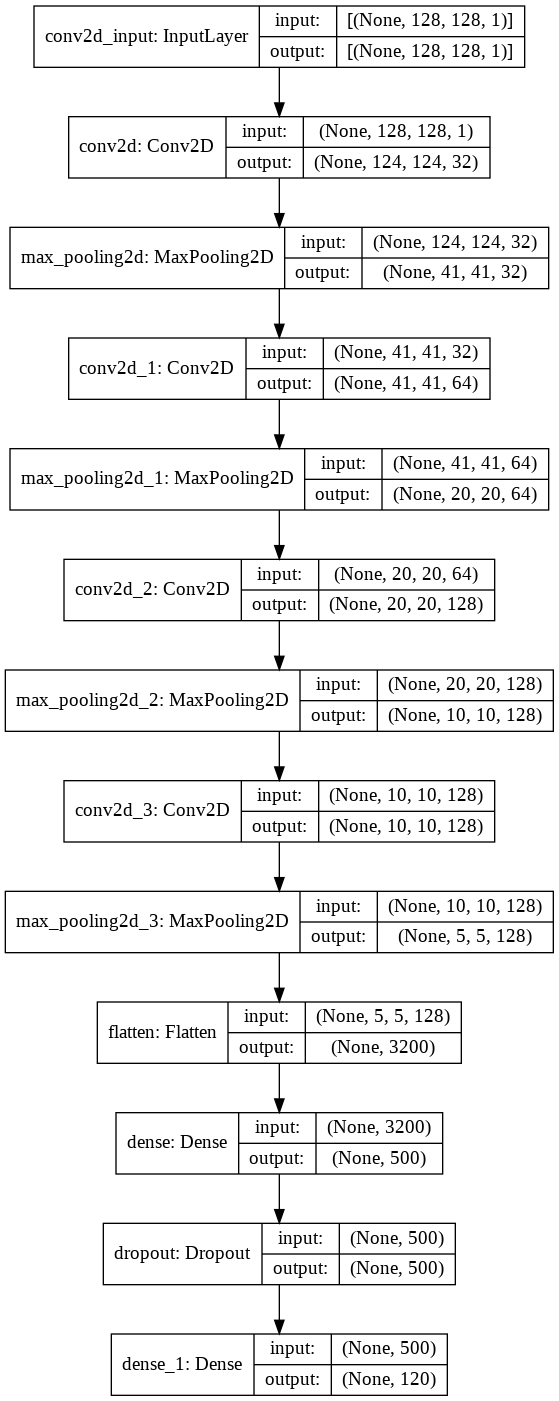

In [31]:
tf.keras.utils.plot_model(model1, show_shapes=True, show_layer_names=True)

In [32]:
history = model1.fit(x_train, y_train,
                     batch_size=BATCH,
                     epochs=EPOCHS,
                     validation_data=(x_val,y_val),
                     callbacks = [model_checkpoint,model_lr],
                     verbose=1)

Epoch 1/20
256/256 [==============================] - 40s 38ms/step - loss: 6.3578 - accuracy: 0.0101 - top5_acc: 0.0455 - val_loss: 4.7833 - val_accuracy: 0.0103 - val_top5_acc: 0.0611

Epoch 00001: val_accuracy improved from -inf to 0.01027, saving model to dogbreed_cnn.h5
Epoch 2/20
256/256 [==============================] - 9s 34ms/step - loss: 4.7818 - accuracy: 0.0121 - top5_acc: 0.0504 - val_loss: 4.7866 - val_accuracy: 0.0098 - val_top5_acc: 0.0509

Epoch 00002: val_accuracy did not improve from 0.01027
Epoch 3/20
256/256 [==============================] - 9s 34ms/step - loss: 4.7769 - accuracy: 0.0113 - top5_acc: 0.0580 - val_loss: 4.7845 - val_accuracy: 0.0098 - val_top5_acc: 0.0533

Epoch 00003: val_accuracy did not improve from 0.01027
Epoch 4/20
256/256 [==============================] - 9s 33ms/step - loss: 4.7846 - accuracy: 0.0088 - top5_acc: 0.0507 - val_loss: 4.7855 - val_accuracy: 0.0108 - val_top5_acc: 0.0572

Epoch 00004: val_accuracy improved from 0.01027 to 0.010

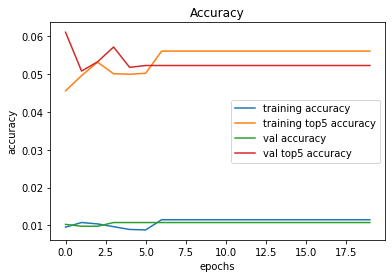

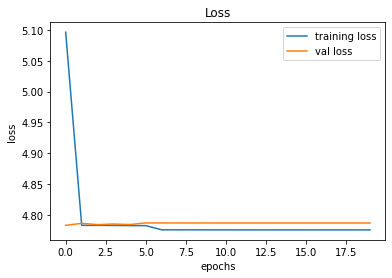

In [33]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['top5_acc'], label='training top5 accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.plot(history.history['val_top5_acc'], label='val top5 accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [34]:
y_predict = model1.predict(x_val)
y_pred = []
y_roc_auc=[]
for val in y_predict:
    y_pred.append(np.argmax(val))
    y_roc_auc.append(val)
cm = metrics.confusion_matrix(np.argmax(y_val,axis=1),y_pred)
print(cm)

[[ 0 20  0 ...  0  0  0]
 [ 0 22  0 ...  0  0  0]
 [ 0 26  0 ...  0  0  0]
 ...
 [ 0 15  0 ...  0  0  0]
 [ 0 14  0 ...  0  0  0]
 [ 0 16  0 ...  0  0  0]]


In [35]:
cr=metrics.classification_report(np.argmax(y_val,axis=1),y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.01      1.00      0.02        22
           2       0.00      0.00      0.00        26
           3       0.00      0.00      0.00        27
           4       0.00      0.00      0.00        12
           5       0.00      0.00      0.00        19
           6       0.00      0.00      0.00        26
           7       0.00      0.00      0.00        20
           8       0.00      0.00      0.00        15
           9       0.00      0.00      0.00        19
          10       0.00      0.00      0.00        29
          11       0.00      0.00      0.00        26
          12       0.00      0.00      0.00        14
          13       0.00      0.00      0.00        26
          14       0.00      0.00      0.00        21
          15       0.00      0.00      0.00        17
          16       0.00      0.00      0.00        12
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
print ('ROC-AUC Score: ', metrics.roc_auc_score(y_val,y_roc_auc,average='weighted',multi_class='ovo'))

ROC-AUC Score:  0.5


In [37]:
#plt.imshow(x_val[20])
print('Actual Dog Breed: ',encoder.inverse_transform([np.argmax(y_val[42])]))
print('Predicted Dog Breed: ',encoder.inverse_transform([y_pred[42]]))

Actual Dog Breed:  ['bernese_mountain_dog']
Predicted Dog Breed:  ['afghan_hound']


### Throwing in ImageAugmentation to understand if any improvement is achieved

In [38]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                #rescale=1./255,
                                                                rotation_range=30,
                                                                shear_range=0.2,
                                                                zoom_range=0.2,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                fill_mode='nearest')
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [39]:
training_data = train_datagen.flow(x_train,y=y_train,batch_size=BATCH)
testing_data = test_datagen.flow(x_val,y=y_val,batch_size=BATCH)

In [40]:
model2 = Sequential()
#model2.add(ZeroPadding2D((1,1),input_shape=(IMG_SIZE,IMG_SIZE,channels)))
model2.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,channels)))
#model2.add(ZeroPadding2D((1,1)))

model2.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model2.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model2.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
model2.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Flatten())
model2.add(Dense(units=500,activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(units=120,activation='softmax'))

model2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy',top5_acc])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 32)      320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 122, 122, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 59, 59, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 57, 57, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 64)       

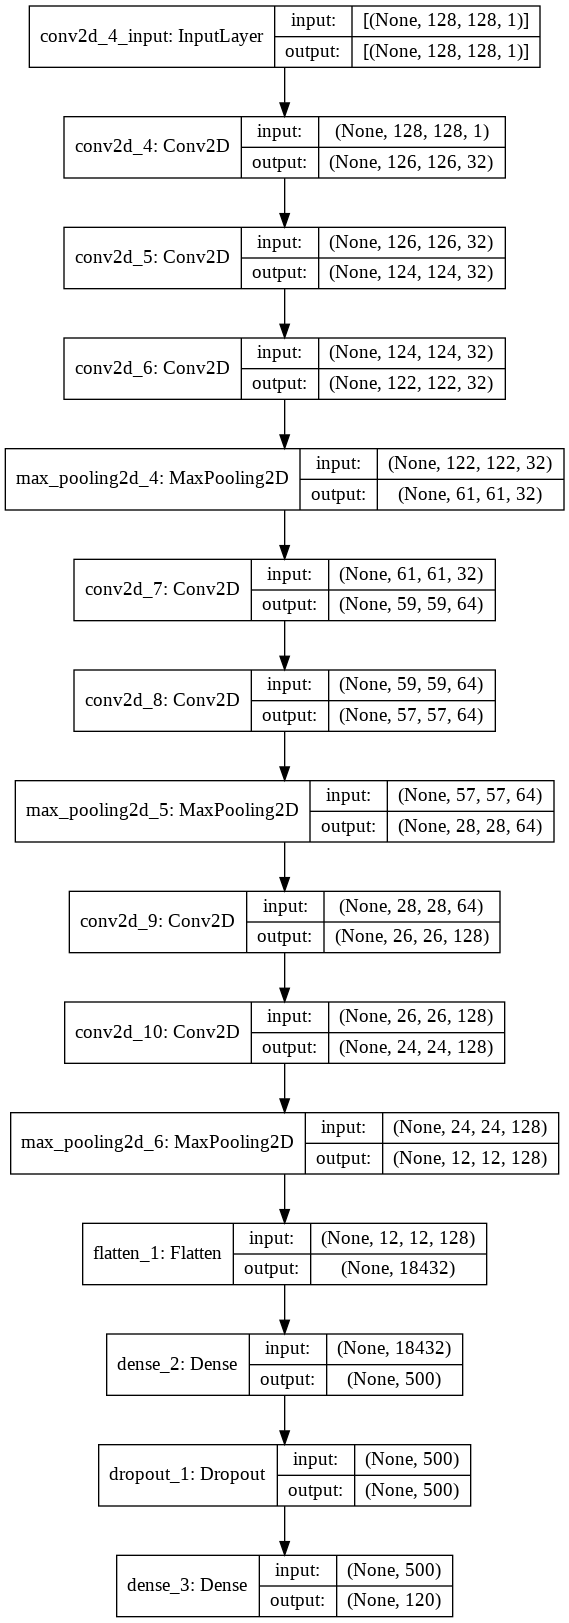

In [41]:
tf.keras.utils.plot_model(model2, show_shapes=True, show_layer_names=True)

In [42]:
history = model2.fit(training_data,
                     epochs=EPOCHS,
                     steps_per_epoch= 8177//BATCH,  #Number of training images//batch_size
                     validation_data=testing_data,
                     validation_steps = 2045//BATCH, #Number of test images//batch_size
                     callbacks = [model_checkpoint,model_lr],
                     verbose=1)

Epoch 1/20
255/255 [==============================] - 33s 122ms/step - loss: 4.7893 - accuracy: 0.0098 - top5_acc: 0.0447 - val_loss: 4.7843 - val_accuracy: 0.0099 - val_top5_acc: 0.0536

Epoch 00001: val_accuracy did not improve from 0.01076
Epoch 2/20
255/255 [==============================] - 30s 116ms/step - loss: 4.7819 - accuracy: 0.0108 - top5_acc: 0.0487 - val_loss: 4.7850 - val_accuracy: 0.0099 - val_top5_acc: 0.0491

Epoch 00002: val_accuracy did not improve from 0.01076
Epoch 3/20
255/255 [==============================] - 30s 116ms/step - loss: 4.7773 - accuracy: 0.0105 - top5_acc: 0.0552 - val_loss: 4.7835 - val_accuracy: 0.0099 - val_top5_acc: 0.0541

Epoch 00003: val_accuracy did not improve from 0.01076
Epoch 4/20
255/255 [==============================] - 30s 116ms/step - loss: 4.7784 - accuracy: 0.0093 - top5_acc: 0.0510 - val_loss: 4.7850 - val_accuracy: 0.0109 - val_top5_acc: 0.0516

Epoch 00004: val_accuracy improved from 0.01076 to 0.01091, saving model to dogbree

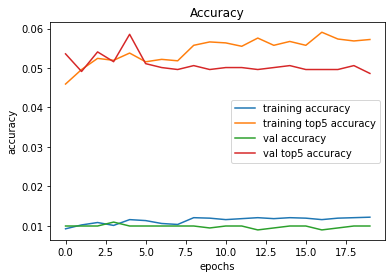

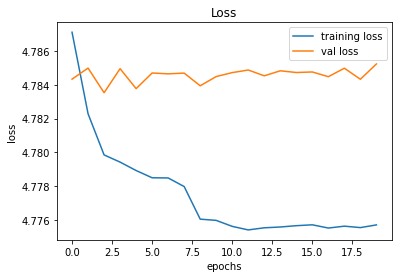

In [43]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['top5_acc'], label='training top5 accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.plot(history.history['val_top5_acc'], label='val top5 accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [44]:
y_predict = model2.predict(x_val)
y_pred = []
y_roc_auc=[]
for val in y_predict:
    y_pred.append(np.argmax(val))
    y_roc_auc.append(val)
cm = metrics.confusion_matrix(np.argmax(y_val,axis=1),y_pred)
print(cm)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [45]:
cr=metrics.classification_report(np.argmax(y_val,axis=1),y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.00      0.00      0.00        22
           2       0.00      0.00      0.00        26
           3       0.00      0.00      0.00        27
           4       0.00      0.00      0.00        12
           5       0.00      0.00      0.00        19
           6       0.00      0.00      0.00        26
           7       0.00      0.00      0.00        20
           8       0.00      0.00      0.00        15
           9       0.00      0.00      0.00        19
          10       0.00      0.00      0.00        29
          11       0.00      0.00      0.00        26
          12       0.00      0.00      0.00        14
          13       0.00      0.00      0.00        26
          14       0.00      0.00      0.00        21
          15       0.00      0.00      0.00        17
          16       0.00      0.00      0.00        12
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
print ('ROC-AUC Score: ', metrics.roc_auc_score(y_val,y_roc_auc,average='weighted',multi_class='ovo'))

ROC-AUC Score:  0.5


In [47]:
#plt.imshow(x_val[20])
print('Actual Dog Breed: ',encoder.inverse_transform([np.argmax(y_val[42])]))
print('Predicted Dog Breed: ',encoder.inverse_transform([y_pred[42]]))

Actual Dog Breed:  ['bernese_mountain_dog']
Predicted Dog Breed:  ['maltese_dog']


## Reading the images once again, this time in 3 Channels

In [16]:
IMG_SIZE=128
channels=3
EPOCHS=20
BATCH=32

In [17]:
x_features=[]
label=[]

for f, img in tqdm(labels.values): #f for image id, img for dog breed
  #Using cv2.imread results in BGR images, instead of the standard RGB as below
  train_img = cv2.imread('./train/{}.jpg'.format(f),1) #0 for grayscale & 1 for color (o/p is bgr)
  train_img_resize = cv2.resize(train_img, (IMG_SIZE,IMG_SIZE))
  x_features.append(train_img_resize)
  label.append(img)

100%|██████████| 10222/10222 [00:32<00:00, 319.36it/s]


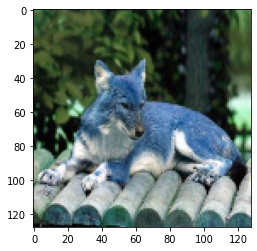

In [ ]:
plt.imshow(x_features[42])

In [18]:
encoder = LabelEncoder()
label = encoder.fit_transform(label)
y_label=tf.keras.utils.to_categorical(label, num_classes=None, dtype='int')#, 120)

In [19]:
x_features = np.array(x_features,np.float32)/255.0  #Division by 255. for normalisation
print(x_features.shape)

y_label = np.array(y_label)
print(y_label.shape)

(10222, 128, 128, 3)
(10222, 120)


In [20]:
x_train,x_val,y_train,y_val=train_test_split(x_features,y_label,test_size=0.2,random_state=42)
print(x_train.shape)
print(x_val.shape)

(8177, 128, 128, 3)
(2045, 128, 128, 3)


## Using a VGG16 architecture with pre-trained weights suited to this task

In [ ]:
#Download the VGG weight file from here
#https://github.com/MinerKasch/applied_deep_learning/blob/master/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

In [ ]:
# only create and load weights to the convolutional part of the VGG16 network
vgg_model = Sequential()
vgg_model.add(ZeroPadding2D((1,1),input_shape=(128,128, 3)))
vgg_model.add(Conv2D(64, (3,3), activation='relu', name='block1_conv1'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Conv2D(64, (3,3), activation='relu', name='block1_conv2'))
vgg_model.add(MaxPooling2D((2,2), strides=(2,2)))

vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Conv2D(128, (3,3), activation='relu', name='block2_conv1'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Conv2D(128, (3,3), activation='relu', name='block2_conv2'))
vgg_model.add(MaxPooling2D((2,2), strides=(2,2)))

vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Conv2D(256, (3,3), activation='relu', name='block3_conv1'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Conv2D(256, (3,3), activation='relu', name='block3_conv2'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Conv2D(256, (3,3), activation='relu', name='block3_conv3'))
vgg_model.add(MaxPooling2D((2,2), strides=(2,2)))

vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Conv2D(512, (3,3), activation='relu', name='block4_conv1'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Conv2D(512, (3,3), activation='relu', name='block4_conv2'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Conv2D(512, (3,3), activation='relu', name='block4_conv3'))
vgg_model.add(MaxPooling2D((2,2), strides=(2,2)))

vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Conv2D(512, (3,3), activation='relu', name='block5_conv1'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Conv2D(512, (3,3), activation='relu', name='block5_conv2'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Conv2D(512, (3,3), activation='relu', name='block5_conv3'))
vgg_model.add(MaxPooling2D((2,2), strides=(2,2)))

vgg_model.load_weights('/content/drive/My Drive/PGP-AIML/Capstone/Using CNN to classify Dog Breeds based on images/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

vgg_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 130, 130, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 130, 130, 64)      0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 66, 66, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)      

In [ ]:
# Add our own classifier layers on the bottom
vgg_model.add(Flatten(input_shape=(512,)))
vgg_model.add(Dense(256, activation='relu'))
vgg_model.add(Dense(120, activation='softmax'))

# optional set the convolutional layers so they won't be trained.
for layer in vgg_model.layers[:25]:
    layer.trainable = False

adam = Adam(lr=0.0001)
vgg_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy',top5_acc])

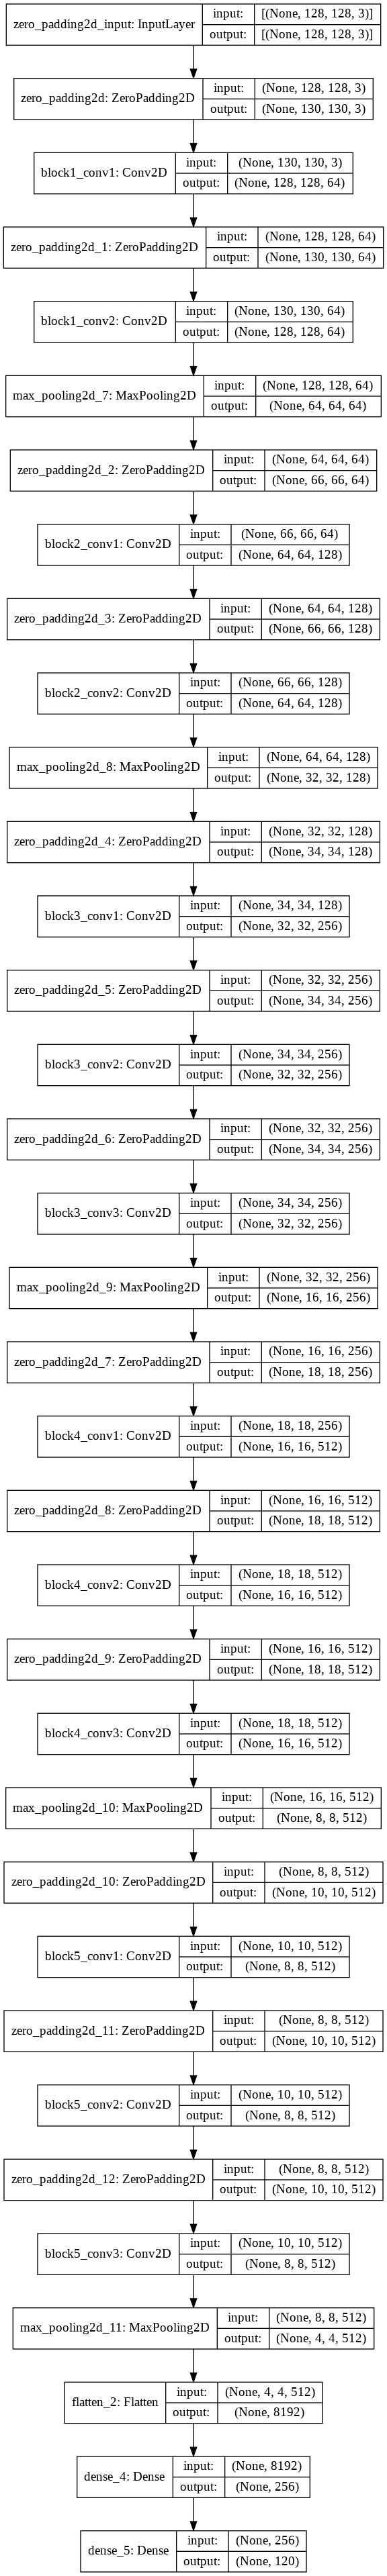

In [ ]:
tf.keras.utils.plot_model(vgg_model, show_shapes=True, show_layer_names=True)

In [ ]:
history = vgg_model.fit(#x_train,np.asarray(y_train),
                        x_train,y_train,
                        validation_data=(x_val,y_val),
                        epochs=EPOCHS,
                        batch_size=BATCH,
                        callbacks = [model_checkpoint,model_lr],
                        verbose=1)

Epoch 1/20
256/256 [==============================] - 21s 74ms/step - loss: 4.7602 - accuracy: 0.0180 - top5_acc: 0.0740 - val_loss: 4.1732 - val_accuracy: 0.0841 - val_top5_acc: 0.2513

Epoch 00001: val_accuracy improved from 0.01760 to 0.08411, saving model to dogbreed_cnn.h5
Epoch 2/20
256/256 [==============================] - 18s 70ms/step - loss: 3.7285 - accuracy: 0.1461 - top5_acc: 0.3737 - val_loss: 3.4612 - val_accuracy: 0.1814 - val_top5_acc: 0.4528

Epoch 00002: val_accuracy improved from 0.08411 to 0.18142, saving model to dogbreed_cnn.h5
Epoch 3/20
256/256 [==============================] - 18s 70ms/step - loss: 2.5117 - accuracy: 0.3636 - top5_acc: 0.6796 - val_loss: 3.2155 - val_accuracy: 0.2308 - val_top5_acc: 0.5267

Epoch 00003: val_accuracy improved from 0.18142 to 0.23081, saving model to dogbreed_cnn.h5
Epoch 4/20
256/256 [==============================] - 18s 69ms/step - loss: 1.5234 - accuracy: 0.5944 - top5_acc: 0.8560 - val_loss: 3.1016 - val_accuracy: 0.2694 

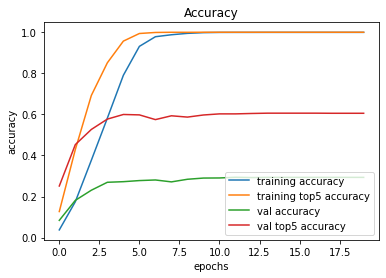

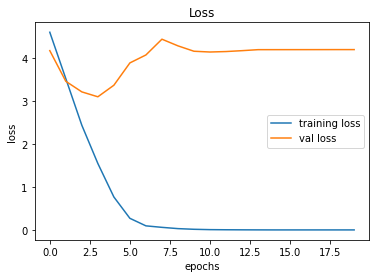

In [ ]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['top5_acc'], label='training top5 accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.plot(history.history['val_top5_acc'], label='val top5 accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [ ]:
y_predict = vgg_model.predict(x_val)
y_pred = []
y_roc_auc=[]
y_top5=[]
for val in y_predict:
    y_pred.append(np.argmax(val))
    y_roc_auc.append(val)
    y_top5.append(np.argsort(val)[-5:])
cm = metrics.confusion_matrix(np.argmax(y_val,axis=1),y_pred)
print(cm)

[[ 5  0  1 ...  0  0  0]
 [ 0 11  0 ...  0  0  0]
 [ 0  0 18 ...  0  0  0]
 ...
 [ 0  1  0 ...  4  0  0]
 [ 0  0  0 ...  0  8  0]
 [ 0  0  0 ...  0  0  3]]


In [ ]:
cr=metrics.classification_report(np.argmax(y_val,axis=1),y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.44      0.20      0.28        20
           1       0.42      0.36      0.39        22
           2       0.67      0.46      0.55        26
           3       0.33      0.11      0.17        27
           4       0.05      0.08      0.06        12
           5       0.33      0.21      0.26        19
           6       0.47      0.54      0.50        26
           7       0.26      0.25      0.26        20
           8       0.00      0.00      0.00        15
           9       0.22      0.26      0.24        19
          10       0.67      0.34      0.45        29
          11       0.35      0.35      0.35        26
          12       0.32      0.43      0.36        14
          13       0.53      0.35      0.42        26
          14       0.14      0.10      0.11        21
          15       0.00      0.00      0.00        17
          16       0.36      0.33      0.35        12
          17       0.33    

In [ ]:
print ('ROC-AUC Score: ', metrics.roc_auc_score(y_val,y_roc_auc,average='weighted',multi_class='ovo'))

ROC-AUC Score:  0.9250727335289316


Actual Dog Breed:  ['bernese_mountain_dog']
Predicted Dog Breed:  ['shetland_sheepdog']


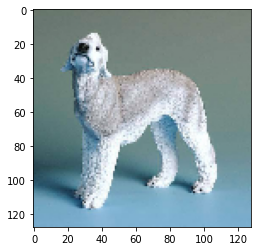

In [ ]:
plt.imshow(x_val[20])
print('Actual Dog Breed: ',encoder.inverse_transform([np.argmax(y_val[42])]))
print('Predicted Dog Breed: ',encoder.inverse_transform([y_pred[42]]))

In [ ]:
for i in range(len(y_val)):
  print('Actual Value: ',encoder.inverse_transform([np.argmax(y_val[i])]))
  print('Predicted Top-5 Breeds: ',encoder.inverse_transform(y_top5[i]))

Streaming output truncated to the last 5000 lines.
Predicted Top-5 Breeds:  ['boston_bull' 'siberian_husky' 'malinois' 'scotch_terrier' 'kelpie']
Actual Value:  ['eskimo_dog']
Predicted Top-5 Breeds:  ['basenji' 'great_pyrenees' 'soft-coated_wheaten_terrier' 'saluki'
 'irish_wolfhound']
Actual Value:  ['american_staffordshire_terrier']
Predicted Top-5 Breeds:  ['ibizan_hound' 'staffordshire_bullterrier' 'english_foxhound'
 'great_dane' 'kuvasz']
Actual Value:  ['scottish_deerhound']
Predicted Top-5 Breeds:  ['irish_wolfhound' 'irish_water_spaniel' 'lhasa' 'tibetan_terrier'
 'newfoundland']
Actual Value:  ['norwich_terrier']
Predicted Top-5 Breeds:  ['airedale' 'scottish_deerhound' 'border_terrier' 'irish_wolfhound'
 'norwich_terrier']
Actual Value:  ['chihuahua']
Predicted Top-5 Breeds:  ['great_pyrenees' 'komondor' 'irish_wolfhound' 'african_hunting_dog'
 'tibetan_terrier']
Actual Value:  ['komondor']
Predicted Top-5 Breeds:  ['tibetan_terrier' 'lhasa' 'komondor' 'bouvier_des_flandres

## Using pre-trained VGG16 architecture, with architecture & weights in tact

In [21]:
base_model = VGG16(weights='/content/drive/My Drive/PGP-AIML/Capstone/Using CNN to classify Dog Breeds based on images/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                   include_top=False, pooling='avg')

for layers in base_model.layers:
  layers.trainable=False

In [ ]:
#X_arr=[]
#X_arr=base_model.predict(preprocess_input(img_to_array(image.load_img('./train/'+labels['id'][0]))))

In [ ]:
x=base_model.output
#x=tf.keras.layers.Dense(1024,input_shape=(512,),activation='relu')(x)
x=tf.keras.layers.Dense(1024,activation='relu')(x)
x=tf.keras.layers.Dense(256,activation='relu')(x)
x=tf.keras.layers.Dense(120,activation='softmax')(x)
model3=tf.keras.Model(inputs=base_model.input,outputs=x)
model3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy',top5_acc])
model3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

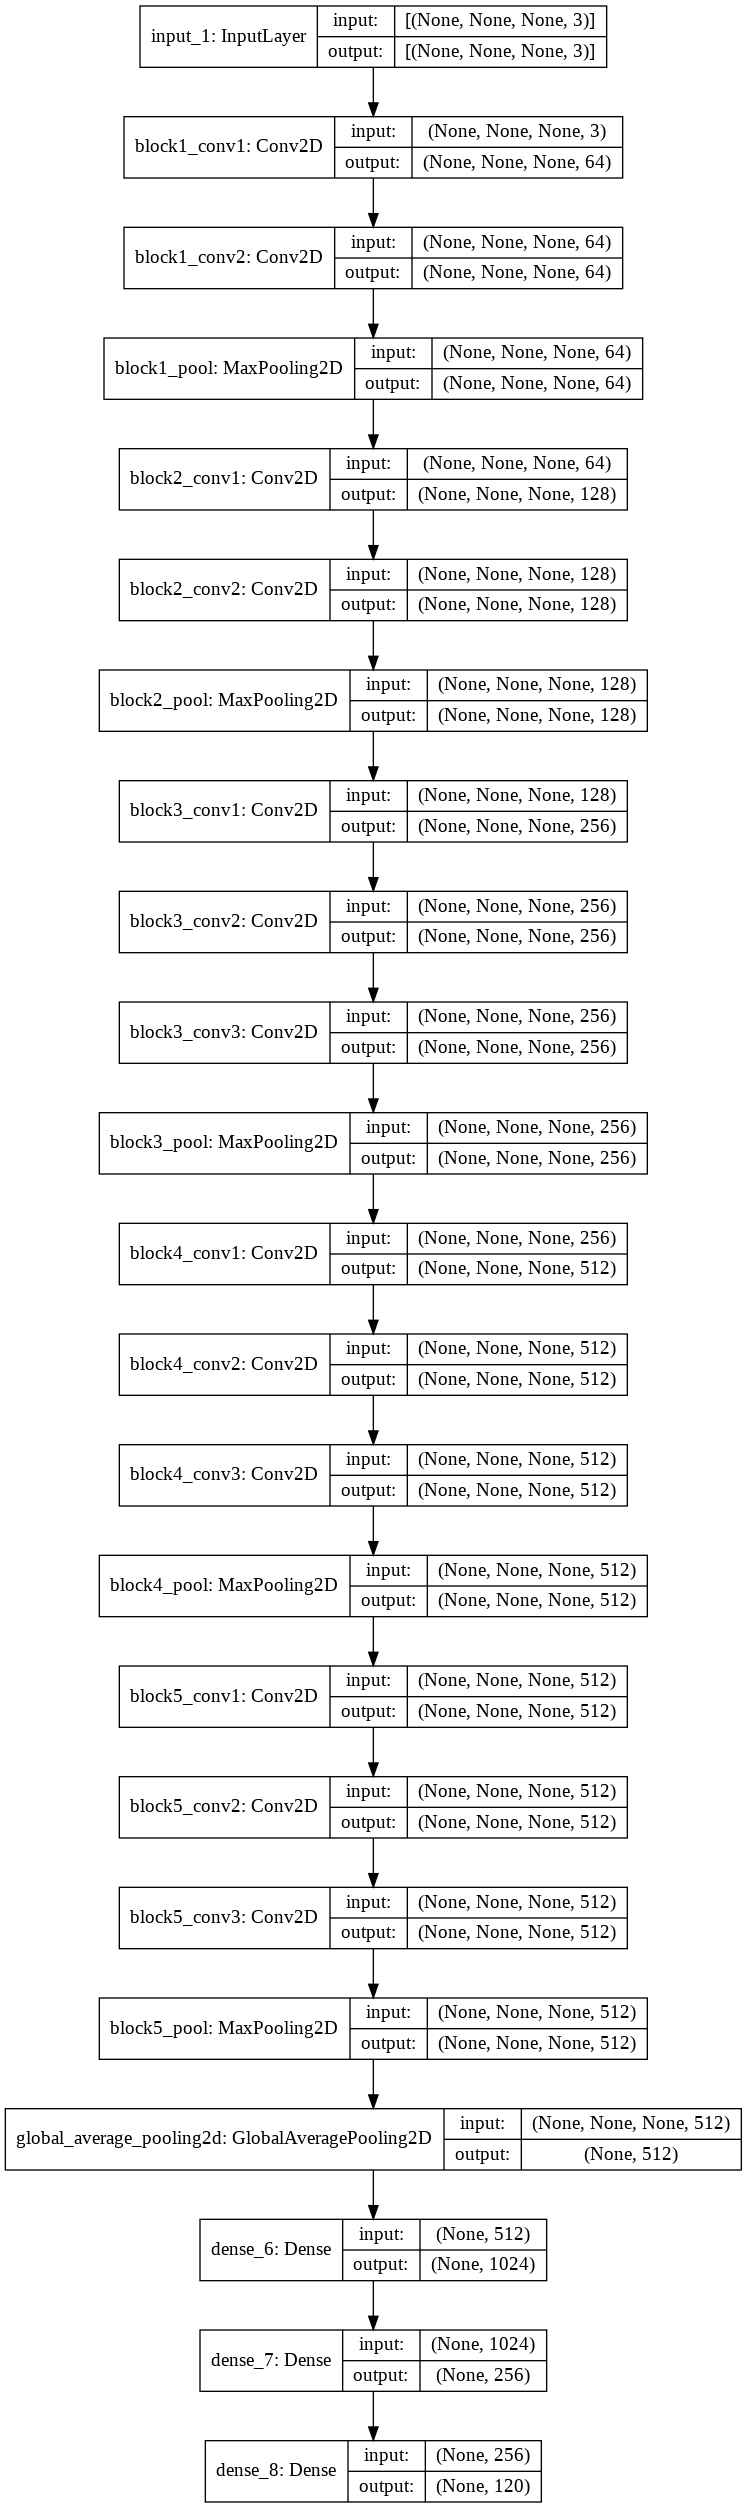

In [ ]:
tf.keras.utils.plot_model(model3, show_shapes=True, show_layer_names=True)

In [ ]:
history = model3.fit(#x_train,np.asarray(y_train),
                     x_train,y_train,
                     validation_data=(x_val,y_val),
                     epochs=EPOCHS,
                     batch_size=BATCH,
                     callbacks = [model_checkpoint,model_lr],
                     verbose=1)

Epoch 1/20
256/256 [==============================] - 16s 57ms/step - loss: 4.7641 - accuracy: 0.0165 - top5_acc: 0.0683 - val_loss: 4.2973 - val_accuracy: 0.0626 - val_top5_acc: 0.2029

Epoch 00001: val_accuracy did not improve from 0.29389
Epoch 2/20
256/256 [==============================] - 13s 51ms/step - loss: 4.0179 - accuracy: 0.0982 - top5_acc: 0.2869 - val_loss: 3.6848 - val_accuracy: 0.1340 - val_top5_acc: 0.3643

Epoch 00002: val_accuracy did not improve from 0.29389
Epoch 3/20
256/256 [==============================] - 13s 52ms/step - loss: 3.4689 - accuracy: 0.1698 - top5_acc: 0.4353 - val_loss: 3.5022 - val_accuracy: 0.1623 - val_top5_acc: 0.4264

Epoch 00003: val_accuracy did not improve from 0.29389
Epoch 4/20
256/256 [==============================] - 13s 51ms/step - loss: 3.1665 - accuracy: 0.2172 - top5_acc: 0.5178 - val_loss: 3.3577 - val_accuracy: 0.1907 - val_top5_acc: 0.4689

Epoch 00004: val_accuracy did not improve from 0.29389
Epoch 5/20
256/256 [============

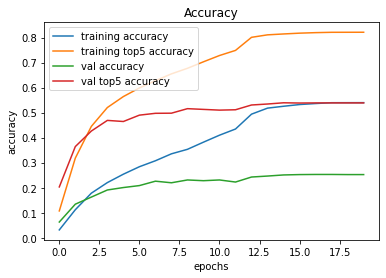

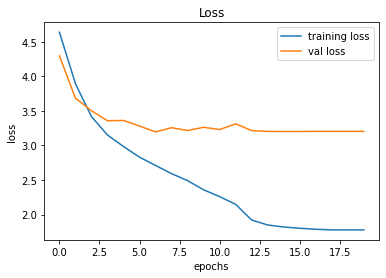

In [ ]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['top5_acc'], label='training top5 accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.plot(history.history['val_top5_acc'], label='val top5 accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [ ]:
y_predict = model3.predict(x_val)
y_pred = []
y_roc_auc=[]
y_top5=[]
for val in y_predict:
    y_pred.append(np.argmax(val))
    y_roc_auc.append(val)
    y_top5.append(np.argsort(val)[-5:])
cm = metrics.confusion_matrix(np.argmax(y_val,axis=1),y_pred)
print(cm)

[[ 6  0  2 ...  0  0  1]
 [ 0 13  0 ...  0  0  0]
 [ 0  0 15 ...  0  0  0]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 0  0  0 ...  0  6  0]
 [ 0  0  0 ...  0  0  5]]


In [ ]:
cr=metrics.classification_report(np.argmax(y_val,axis=1),y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.35      0.30      0.32        20
           1       0.37      0.59      0.46        22
           2       0.52      0.58      0.55        26
           3       0.17      0.15      0.16        27
           4       0.06      0.08      0.07        12
           5       0.11      0.05      0.07        19
           6       0.47      0.27      0.34        26
           7       0.29      0.40      0.33        20
           8       0.18      0.20      0.19        15
           9       0.24      0.21      0.22        19
          10       0.52      0.41      0.46        29
          11       0.30      0.38      0.34        26
          12       0.26      0.43      0.32        14
          13       0.56      0.58      0.57        26
          14       0.45      0.24      0.31        21
          15       0.14      0.12      0.13        17
          16       0.15      0.33      0.21        12
          17       0.25    

In [ ]:
print ('ROC-AUC Score: ', metrics.roc_auc_score(y_val,y_roc_auc,average='weighted',multi_class='ovo'))

ROC-AUC Score:  0.91697895412869


Actual Dog Breed:  ['bernese_mountain_dog']
Predicted Dog Breed:  ['samoyed']


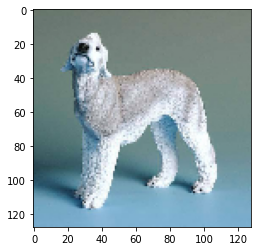

In [ ]:
plt.imshow(x_val[20])
print('Actual Dog Breed: ',encoder.inverse_transform([np.argmax(y_val[42])]))
print('Predicted Dog Breed: ',encoder.inverse_transform([y_pred[42]]))

In [ ]:
for i in range(len(y_val)):
  print('Actual Value: ',encoder.inverse_transform([np.argmax(y_val[i])]))
  print('Predicted Top-5 Breeds: ',encoder.inverse_transform(y_top5[i]))

Streaming output truncated to the last 5000 lines.
 'maltese_dog']
Actual Value:  ['samoyed']
Predicted Top-5 Breeds:  ['border_collie' 'siberian_husky' 'kelpie' 'irish_terrier' 'weimaraner']
Actual Value:  ['tibetan_terrier']
Predicted Top-5 Breeds:  ['miniature_poodle' 'irish_water_spaniel' 'cocker_spaniel'
 'standard_poodle' 'tibetan_terrier']
Actual Value:  ['chow']
Predicted Top-5 Breeds:  ['shih-tzu' 'tibetan_terrier' 'blenheim_spaniel' 'dandie_dinmont'
 'welsh_springer_spaniel']
Actual Value:  ['siberian_husky']
Predicted Top-5 Breeds:  ['whippet' 'american_staffordshire_terrier' 'italian_greyhound'
 'french_bulldog' 'boston_bull']
Actual Value:  ['keeshond']
Predicted Top-5 Breeds:  ['soft-coated_wheaten_terrier' 'briard' 'lhasa' 'pekinese' 'chow']
Actual Value:  ['whippet']
Predicted Top-5 Breeds:  ['appenzeller' 'italian_greyhound' 'bluetick' 'boston_bull'
 'greater_swiss_mountain_dog']
Actual Value:  ['maltese_dog']
Predicted Top-5 Breeds:  ['chihuahua' 'brittany_spaniel' 's

### Pre-trained VGG16 with weights & architecture in tact, trained with Image Augmentation

In [22]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                #rescale=1./255,
                                                                rotation_range=30,
                                                                shear_range=0.2,
                                                                zoom_range=0.2,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                fill_mode='nearest')
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

In [23]:
training_data = train_datagen.flow(x_train,y=y_train,batch_size=BATCH)
testing_data = test_datagen.flow(x_val,y=y_val,batch_size=BATCH)

In [24]:
x=base_model.output
#x=tf.keras.layers.Dense(1024,input_shape=(512,),activation='relu')(x)
x=tf.keras.layers.Dense(1024,activation='relu')(x)
x=tf.keras.layers.Dense(256,activation='relu')(x)
x=tf.keras.layers.Dense(120,activation='softmax')(x)
model4=tf.keras.Model(inputs=base_model.input,outputs=x)
model4.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy',top5_acc])
model4.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

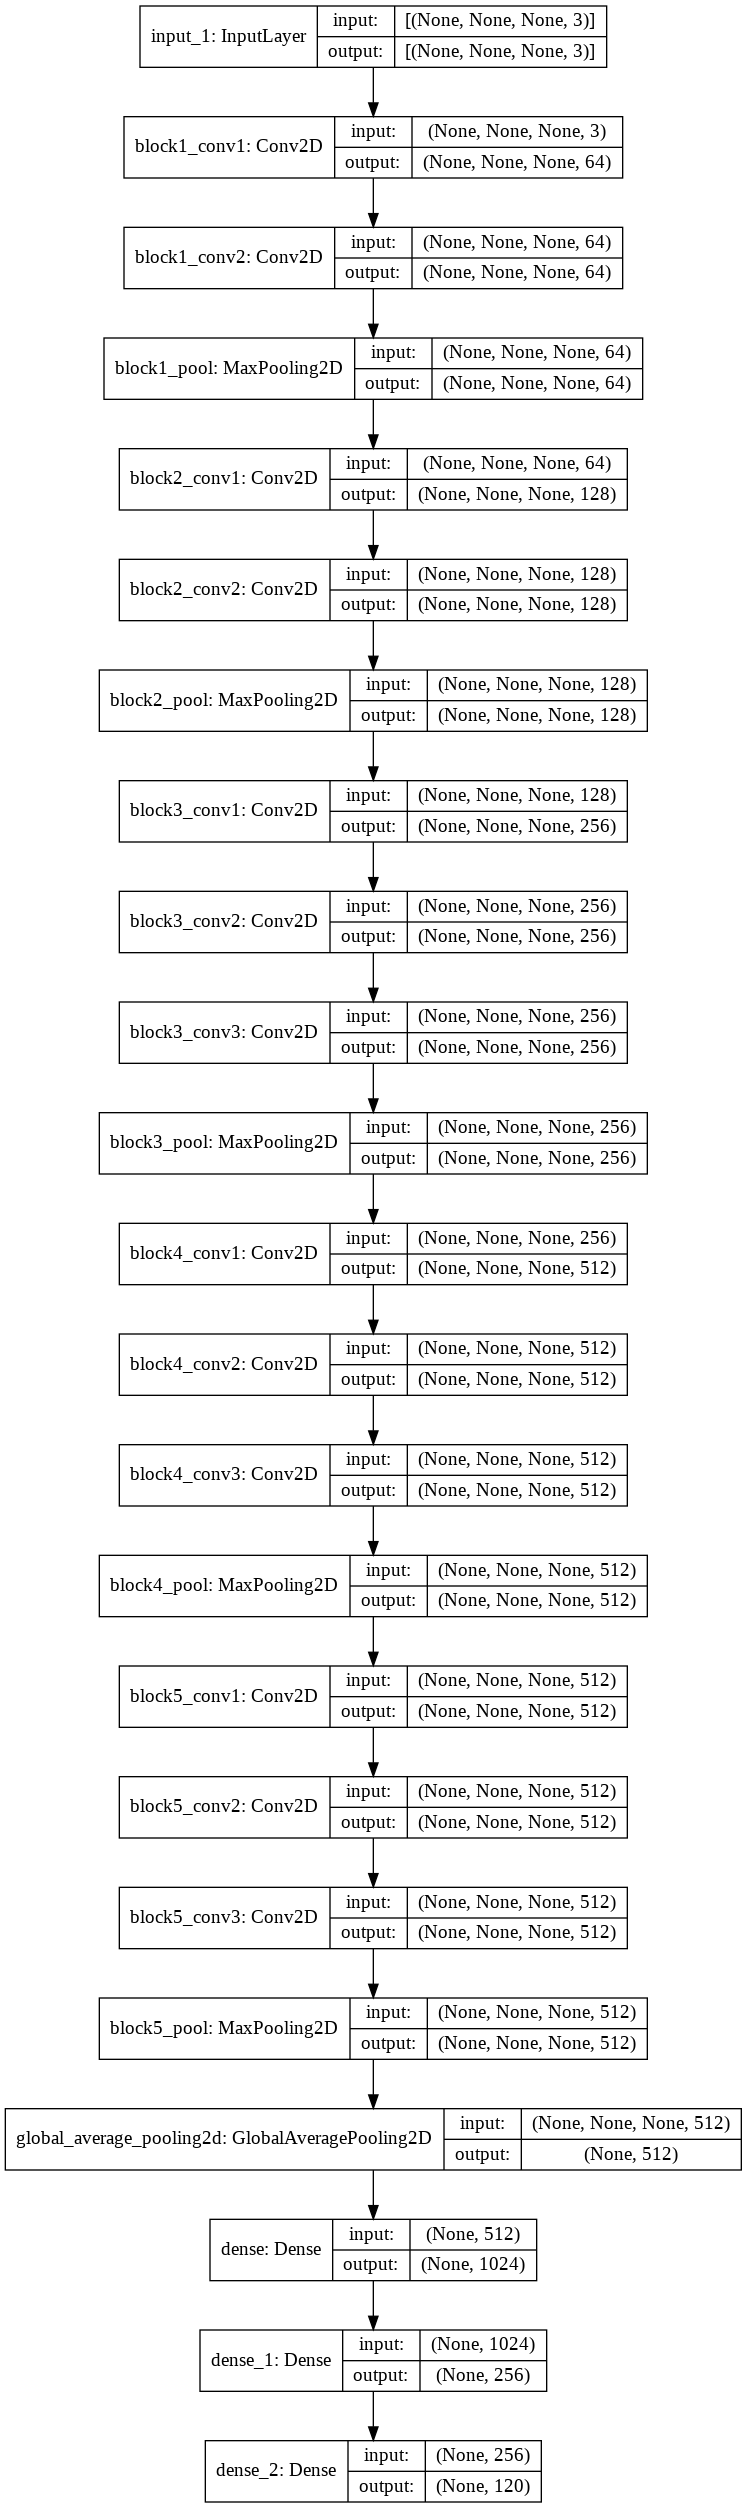

In [25]:
tf.keras.utils.plot_model(model4, show_shapes=True, show_layer_names=True)

In [26]:
history = model4.fit(training_data,
                     epochs=EPOCHS,
                     steps_per_epoch= 8177//BATCH,  #Number of training images//batch_size
                     validation_data=testing_data,
                     validation_steps = 2045//BATCH, #Number of test images//batch_size
                     callbacks = [model_checkpoint,model_lr],
                     verbose=1)

Epoch 1/20
255/255 [==============================] - 72s 191ms/step - loss: 4.8126 - accuracy: 0.0114 - top5_acc: 0.0516 - val_loss: 4.7051 - val_accuracy: 0.0293 - val_top5_acc: 0.0938

Epoch 00001: val_accuracy improved from -inf to 0.02927, saving model to dogbreed_cnn.h5
Epoch 2/20
255/255 [==============================] - 45s 177ms/step - loss: 4.6241 - accuracy: 0.0312 - top5_acc: 0.1151 - val_loss: 4.3807 - val_accuracy: 0.0516 - val_top5_acc: 0.1667

Epoch 00002: val_accuracy improved from 0.02927 to 0.05159, saving model to dogbreed_cnn.h5
Epoch 3/20
255/255 [==============================] - 45s 177ms/step - loss: 4.3173 - accuracy: 0.0532 - top5_acc: 0.1939 - val_loss: 4.0110 - val_accuracy: 0.0883 - val_top5_acc: 0.2708

Epoch 00003: val_accuracy improved from 0.05159 to 0.08829, saving model to dogbreed_cnn.h5
Epoch 4/20
255/255 [==============================] - 46s 180ms/step - loss: 4.0493 - accuracy: 0.0841 - top5_acc: 0.2728 - val_loss: 3.8325 - val_accuracy: 0.1121

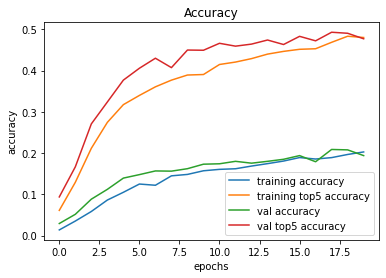

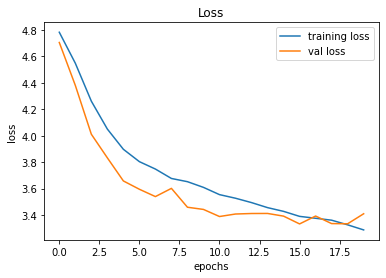

In [27]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['top5_acc'], label='training top5 accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.plot(history.history['val_top5_acc'], label='val top5 accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [28]:
y_predict = model4.predict(x_val)
y_pred = []
y_roc_auc=[]
y_top5=[]
for val in y_predict:
    y_pred.append(np.argmax(val))
    y_roc_auc.append(val)
    y_top5.append(np.argsort(val)[-5:])
cm = metrics.confusion_matrix(np.argmax(y_val,axis=1),y_pred)
print(cm)

[[ 0  1  1 ...  0  0  1]
 [ 1 10  0 ...  0  0  0]
 [ 0  0 12 ...  0  0  0]
 ...
 [ 0  0  0 ...  2  0  0]
 [ 0  0  0 ...  0  1  0]
 [ 0  0  0 ...  0  0  4]]


In [29]:
cr=metrics.classification_report(np.argmax(y_val,axis=1),y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.26      0.45      0.33        22
           2       0.44      0.46      0.45        26
           3       0.14      0.15      0.14        27
           4       0.00      0.00      0.00        12
           5       0.00      0.00      0.00        19
           6       0.50      0.19      0.28        26
           7       0.09      0.55      0.16        20
           8       0.00      0.00      0.00        15
           9       0.17      0.32      0.22        19
          10       0.41      0.45      0.43        29
          11       0.47      0.31      0.37        26
          12       0.25      0.07      0.11        14
          13       0.60      0.23      0.33        26
          14       0.21      0.19      0.20        21
          15       0.07      0.12      0.09        17
          16       0.33      0.08      0.13        12
          17       0.22    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
print ('ROC-AUC Score: ', metrics.roc_auc_score(y_val,y_roc_auc,average='weighted',multi_class='ovo'))

ROC-AUC Score:  0.8988695296610373


Actual Dog Breed:  ['bernese_mountain_dog']
Predicted Dog Breed:  ['samoyed']


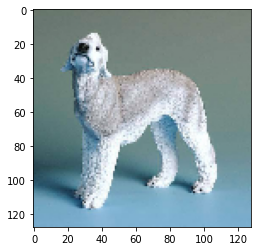

In [31]:
plt.imshow(x_val[20])
print('Actual Dog Breed: ',encoder.inverse_transform([np.argmax(y_val[42])]))
print('Predicted Dog Breed: ',encoder.inverse_transform([y_pred[42]]))

In [32]:
for i in range(len(y_val)):
  print('Actual Value: ',encoder.inverse_transform([np.argmax(y_val[i])]))
  print('Predicted Top-5 Breeds: ',encoder.inverse_transform(y_top5[i]))

Streaming output truncated to the last 5000 lines.
Actual Value:  ['silky_terrier']
Predicted Top-5 Breeds:  ['afghan_hound' 'irish_setter' 'gordon_setter' 'sussex_spaniel'
 'silky_terrier']
Actual Value:  ['basset']
Predicted Top-5 Breeds:  ['english_foxhound' 'basset' 'labrador_retriever' 'walker_hound' 'beagle']
Actual Value:  ['toy_poodle']
Predicted Top-5 Breeds:  ['miniature_poodle' 'komondor' 'soft-coated_wheaten_terrier' 'clumber'
 'sussex_spaniel']
Actual Value:  ['australian_terrier']
Predicted Top-5 Breeds:  ['scotch_terrier' 'silky_terrier' 'yorkshire_terrier' 'norwich_terrier'
 'australian_terrier']
Actual Value:  ['pomeranian']
Predicted Top-5 Breeds:  ['great_pyrenees' 'toy_poodle' 'maltese_dog' 'pomeranian' 'samoyed']
Actual Value:  ['affenpinscher']
Predicted Top-5 Breeds:  ['lakeland_terrier' 'irish_water_spaniel' 'gordon_setter'
 'norwich_terrier' 'airedale']
Actual Value:  ['tibetan_mastiff']
Predicted Top-5 Breeds:  ['norwegian_elkhound' 'leonberg' 'borzoi' 'bull_m

In [ ]:
#model4=tf.keras.Model(inputs=base_model.input,outputs=x)
#model4.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy',top5_acc])
#history = model4.fit(training_data,epochs=EPOCHS,steps_per_epoch= 8177//BATCH,  #Number of training images//batch_size
                     #validation_data=testing_data, validation_steps = 2045//BATCH, #Number of test images//batch_size
                     #callbacks = [model_checkpoint,model_es,model_lr],verbose=1)

## Reading the images once again as the below architectures (Resnet50 & MobileNet) require the input images in a different shape (224X224X3) than the VGG16 model we have been working on so far

In [16]:
IMG_SIZE=224
channels=3
EPOCHS=20
BATCH=32
NUM_IMAGES = 10000

In [17]:
x_features=[]
label=[]

for f, img in tqdm(labels.values): #f for image id, img for dog breed
  #Using cv2.imread results in BGR images, instead of the standard RGB as below
  train_img = cv2.imread('./train/{}.jpg'.format(f),1) #0 for grayscale & 1 for color (o/p is bgr)
  train_img_resize = cv2.resize(train_img, (IMG_SIZE,IMG_SIZE))
  x_features.append(train_img_resize)
  label.append(img)

100%|██████████| 10222/10222 [00:34<00:00, 299.42it/s]


In [18]:
encoder = LabelEncoder()
label = encoder.fit_transform(label)
y_label=tf.keras.utils.to_categorical(label, num_classes=120, dtype='int')#, 120)

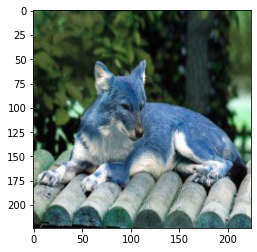

In [ ]:
plt.imshow(x_features[42])

In [19]:
# Set number of images to use for experimenting
x_train,x_val,y_train,y_val=train_test_split(x_features[:NUM_IMAGES],
                                             y_label[:NUM_IMAGES],
                                             test_size=0.2,
                                             random_state=42)

In [20]:
x_train = np.array(x_train,np.float32)/255.0  #Division by 255. for normalisation
print(x_train.shape)

x_val = np.array(x_val,np.float32)/255.0  #Division by 255. for normalisation
print(x_val.shape)

#y_train = np.array(y_train)
#print(y_train.shape)

#y_val = np.array(y_val)
#print(y_val.shape)

(8000, 224, 224, 3)
(2000, 224, 224, 3)


## Verifying with a Resnet50 model trained on ImageNet dataset (not strictly on a dog subset of the same)

In [21]:
base_model = tf.keras.applications.ResNet50(include_top=False,
                                            weights='imagenet',
                                            input_shape=(IMG_SIZE,IMG_SIZE,channels),
                                            pooling='max')
for layers in base_model.layers:
  layers.trainable=False

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
x=base_model.output
#x=tf.keras.layers.Dense(1024,input_shape=(512,),activation='relu')(x)
x=tf.keras.layers.Dense(1024,activation='relu')(x)
x=tf.keras.layers.Dense(256,activation='relu')(x)
x=tf.keras.layers.Dense(120,activation='softmax')(x)
model5=tf.keras.Model(inputs=base_model.input,outputs=x)
model5.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy',top5_acc])
model5.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
tf.keras.utils.plot_model(model5, show_shapes=True, show_layer_names=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
history = model5.fit(x_train,np.asarray(y_train),
                     #x_train,y_train,
                     validation_data=(x_val,np.asarray(y_val)),
                     epochs=EPOCHS,
                     batch_size=BATCH,
                     callbacks = [model_checkpoint,model_lr],
                     verbose=1)

Epoch 1/20
250/250 [==============================] - 53s 79ms/step - loss: 5.0191 - accuracy: 0.0069 - top5_acc: 0.0449 - val_loss: 4.7862 - val_accuracy: 0.0100 - val_top5_acc: 0.0570

Epoch 00001: val_accuracy improved from -inf to 0.01000, saving model to dogbreed_cnn.h5
Epoch 2/20
250/250 [==============================] - 19s 74ms/step - loss: 4.7848 - accuracy: 0.0103 - top5_acc: 0.0569 - val_loss: 4.7852 - val_accuracy: 0.0075 - val_top5_acc: 0.0570

Epoch 00002: val_accuracy did not improve from 0.01000
Epoch 3/20
250/250 [==============================] - 19s 74ms/step - loss: 4.7823 - accuracy: 0.0117 - top5_acc: 0.0610 - val_loss: 4.7847 - val_accuracy: 0.0075 - val_top5_acc: 0.0570

Epoch 00003: val_accuracy did not improve from 0.01000
Epoch 4/20
250/250 [==============================] - 19s 74ms/step - loss: 4.7805 - accuracy: 0.0104 - top5_acc: 0.0557 - val_loss: 4.7844 - val_accuracy: 0.0075 - val_top5_acc: 0.0570

Epoch 00004: val_accuracy did not improve from 0.0100

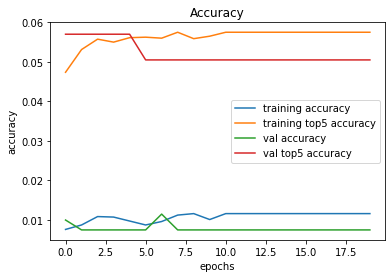

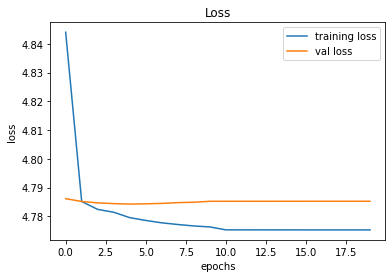

In [ ]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['top5_acc'], label='training top5 accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.plot(history.history['val_top5_acc'], label='val top5 accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [ ]:
y_predict = model5.predict(x_val)
y_pred = []
y_roc_auc=[]
y_top5=[]
for val in y_predict:
    y_pred.append(np.argmax(val))
    y_roc_auc.append(val)
    y_top5.append(np.argsort(val)[-5:])
cm = metrics.confusion_matrix(np.argmax(y_val,axis=1),y_pred)
print(cm)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
cr=metrics.classification_report(np.argmax(y_val,axis=1),y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.00      0.00      0.00        23
           2       0.00      0.00      0.00        21
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        20
           6       0.00      0.00      0.00        18
           7       0.01      1.00      0.01        15
           8       0.00      0.00      0.00        13
           9       0.00      0.00      0.00        22
          10       0.00      0.00      0.00        22
          11       0.00      0.00      0.00        23
          12       0.00      0.00      0.00        12
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00        19
          15       0.00      0.00      0.00        18
          16       0.00      0.00      0.00        14
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print ('ROC-AUC Score: ', metrics.roc_auc_score(y_val,y_roc_auc,average='weighted',multi_class='ovo'))

ROC-AUC Score:  0.5


Actual Dog Breed:  ['kelpie']
Predicted Dog Breed:  ['basenji']


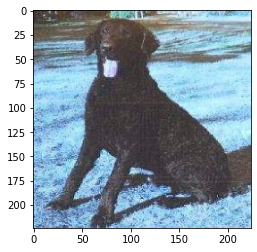

In [ ]:
plt.imshow(x_val[20])
print('Actual Dog Breed: ',encoder.inverse_transform([np.argmax(y_val[42])]))
print('Predicted Dog Breed: ',encoder.inverse_transform([y_pred[42]]))

In [ ]:
for i in range(len(y_val)):
  print('Actual Value: ',encoder.inverse_transform([np.argmax(y_val[i])]))
  print('Predicted Top-5 Breeds: ',encoder.inverse_transform(y_top5[i]))

Actual Value:  ['entlebucher']
Predicted Top-5 Breeds:  ['maltese_dog' 'pomeranian' 'shih-tzu' 'afghan_hound' 'basenji']
Actual Value:  ['pomeranian']
Predicted Top-5 Breeds:  ['maltese_dog' 'pomeranian' 'shih-tzu' 'afghan_hound' 'basenji']
Actual Value:  ['norfolk_terrier']
Predicted Top-5 Breeds:  ['maltese_dog' 'pomeranian' 'shih-tzu' 'afghan_hound' 'basenji']
Actual Value:  ['schipperke']
Predicted Top-5 Breeds:  ['maltese_dog' 'pomeranian' 'shih-tzu' 'afghan_hound' 'basenji']
Actual Value:  ['lhasa']
Predicted Top-5 Breeds:  ['maltese_dog' 'pomeranian' 'shih-tzu' 'afghan_hound' 'basenji']
Actual Value:  ['pembroke']
Predicted Top-5 Breeds:  ['maltese_dog' 'pomeranian' 'shih-tzu' 'afghan_hound' 'basenji']
Actual Value:  ['great_pyrenees']
Predicted Top-5 Breeds:  ['maltese_dog' 'pomeranian' 'shih-tzu' 'afghan_hound' 'basenji']
Actual Value:  ['golden_retriever']
Predicted Top-5 Breeds:  ['maltese_dog' 'pomeranian' 'shih-tzu' 'afghan_hound' 'basenji']
Actual Value:  ['otterhound']
P

### Adding ImageAugmentation to see if there is any improvement of performance

In [22]:
#from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                #rescale=1./255,
                                                                rotation_range=30,
                                                                shear_range=0.2,
                                                                zoom_range=0.2,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                fill_mode='nearest')
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

In [23]:
training_data = train_datagen.flow(x_train,y=np.asarray(y_train),batch_size=BATCH)
testing_data = test_datagen.flow(x_val,y=np.asarray(y_val),batch_size=BATCH)

In [24]:
x=base_model.output
x=tf.keras.layers.Dense(1024,activation='relu')(x)
x=tf.keras.layers.Dense(256,activation='relu')(x)
x=tf.keras.layers.Dense(120,activation='softmax')(x)
model6=tf.keras.Model(inputs=base_model.input,outputs=x)
model6.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy',top5_acc])
model6.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [25]:
tf.keras.utils.plot_model(model6, show_shapes=True, show_layer_names=True)

Output hidden; open in https://colab.research.google.com to view.

In [26]:
history = model6.fit(training_data,
                     epochs=EPOCHS,
                     steps_per_epoch= 8000//BATCH,  #Number of training images//batch_size
                     validation_data=testing_data,
                     validation_steps = 2000//BATCH, #Number of test images//batch_size,
                     callbacks = [model_checkpoint,model_lr],
                     verbose=1)

Epoch 1/20
250/250 [==============================] - 157s 493ms/step - loss: 5.0038 - accuracy: 0.0068 - top5_acc: 0.0437 - val_loss: 4.7863 - val_accuracy: 0.0076 - val_top5_acc: 0.0489

Epoch 00001: val_accuracy improved from -inf to 0.00756, saving model to dogbreed_cnn.h5
Epoch 2/20
250/250 [==============================] - 121s 485ms/step - loss: 4.7850 - accuracy: 0.0108 - top5_acc: 0.0565 - val_loss: 4.7855 - val_accuracy: 0.0076 - val_top5_acc: 0.0484

Epoch 00002: val_accuracy did not improve from 0.00756
Epoch 3/20
250/250 [==============================] - 121s 482ms/step - loss: 4.7823 - accuracy: 0.0106 - top5_acc: 0.0578 - val_loss: 4.7847 - val_accuracy: 0.0076 - val_top5_acc: 0.0504

Epoch 00003: val_accuracy did not improve from 0.00756
Epoch 4/20
250/250 [==============================] - 123s 493ms/step - loss: 4.7811 - accuracy: 0.0099 - top5_acc: 0.0554 - val_loss: 4.7846 - val_accuracy: 0.0076 - val_top5_acc: 0.0509

Epoch 00004: val_accuracy did not improve fro

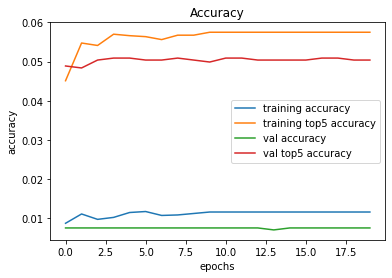

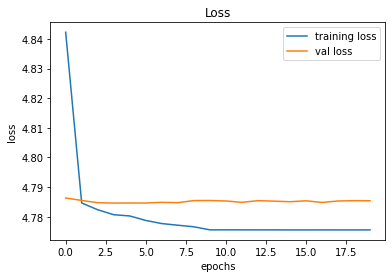

In [27]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['top5_acc'], label='training top5 accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.plot(history.history['val_top5_acc'], label='val top5 accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [28]:
y_predict = model6.predict(x_val)
y_pred = []
y_roc_auc=[]
y_top5=[]
for val in y_predict:
    y_pred.append(np.argmax(val))
    y_roc_auc.append(val)
    y_top5.append(np.argsort(val)[-5:])
cm = metrics.confusion_matrix(np.argmax(y_val,axis=1),y_pred)
print(cm)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [29]:
cr=metrics.classification_report(np.argmax(y_val,axis=1),y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.00      0.00      0.00        23
           2       0.00      0.00      0.00        21
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        20
           6       0.00      0.00      0.00        18
           7       0.01      1.00      0.01        15
           8       0.00      0.00      0.00        13
           9       0.00      0.00      0.00        22
          10       0.00      0.00      0.00        22
          11       0.00      0.00      0.00        23
          12       0.00      0.00      0.00        12
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00        19
          15       0.00      0.00      0.00        18
          16       0.00      0.00      0.00        14
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
print ('ROC-AUC Score: ', metrics.roc_auc_score(y_val,y_roc_auc,average='weighted',multi_class='ovo'))

ROC-AUC Score:  0.5


Actual Dog Breed:  ['kelpie']
Predicted Dog Breed:  ['basenji']


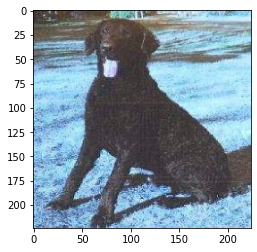

In [31]:
plt.imshow(x_val[20])
print('Actual Dog Breed: ',encoder.inverse_transform([np.argmax(y_val[42])]))
print('Predicted Dog Breed: ',encoder.inverse_transform([y_pred[42]]))

In [32]:
for i in range(len(y_val)):
  print('Actual Value: ',encoder.inverse_transform([np.argmax(y_val[i])]))
  print('Predicted Top-5 Breeds: ',encoder.inverse_transform(y_top5[i]))

Actual Value:  ['entlebucher']
Predicted Top-5 Breeds:  ['maltese_dog' 'pomeranian' 'shih-tzu' 'afghan_hound' 'basenji']
Actual Value:  ['pomeranian']
Predicted Top-5 Breeds:  ['maltese_dog' 'pomeranian' 'shih-tzu' 'afghan_hound' 'basenji']
Actual Value:  ['norfolk_terrier']
Predicted Top-5 Breeds:  ['maltese_dog' 'pomeranian' 'shih-tzu' 'afghan_hound' 'basenji']
Actual Value:  ['schipperke']
Predicted Top-5 Breeds:  ['maltese_dog' 'pomeranian' 'shih-tzu' 'afghan_hound' 'basenji']
Actual Value:  ['lhasa']
Predicted Top-5 Breeds:  ['maltese_dog' 'pomeranian' 'shih-tzu' 'afghan_hound' 'basenji']
Actual Value:  ['pembroke']
Predicted Top-5 Breeds:  ['maltese_dog' 'pomeranian' 'shih-tzu' 'afghan_hound' 'basenji']
Actual Value:  ['great_pyrenees']
Predicted Top-5 Breeds:  ['maltese_dog' 'pomeranian' 'shih-tzu' 'afghan_hound' 'basenji']
Actual Value:  ['golden_retriever']
Predicted Top-5 Breeds:  ['maltese_dog' 'pomeranian' 'shih-tzu' 'afghan_hound' 'basenji']
Actual Value:  ['otterhound']
P

### Further keeping the layers in the Resnet50 architecture as trainable so that the entire network is further trained on the dataset at hand (this is further to the ImageNet data it's already trained on)

In [ ]:
base_model = tf.keras.applications.ResNet50(include_top=False,
                                            weights='imagenet',
                                            input_shape=(IMG_SIZE,IMG_SIZE,channels),
                                            pooling='max')
for layers in base_model.layers:
  layers.trainable=True

In [ ]:
x=base_model.output
#x=tf.keras.layers.Dense(1024,input_shape=(512,),activation='relu')(x)
x=tf.keras.layers.Dense(1024,activation='relu')(x)
x=tf.keras.layers.Dense(256,activation='relu')(x)
x=tf.keras.layers.Dense(120,activation='softmax')(x)
model7=tf.keras.Model(inputs=base_model.input,outputs=x)
model7.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy',top5_acc])
model7.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

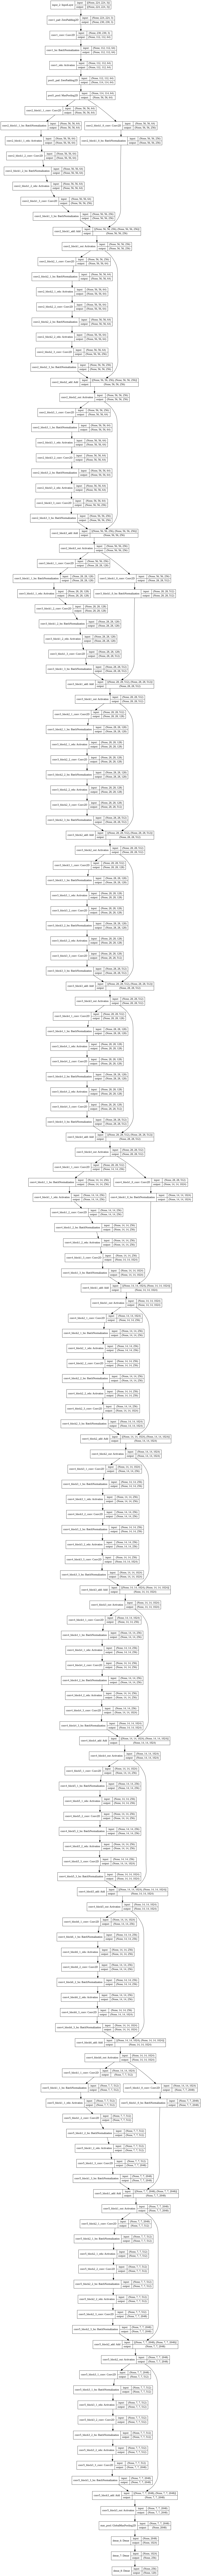

In [ ]:
tf.keras.utils.plot_model(model7, show_shapes=True, show_layer_names=True)

In [ ]:
history = model7.fit(x_train,np.asarray(y_train),
                     #x_train,y_train,
                     validation_data=(x_val,np.asarray(y_val)),
                     epochs=EPOCHS,
                     batch_size=BATCH,
                     callbacks = [model_checkpoint,model_lr],
                     verbose=1)

Epoch 1/20
250/250 [==============================] - 89s 335ms/step - loss: 6.7764 - accuracy: 0.0091 - top5_acc: 0.0463 - val_loss: 8.8113 - val_accuracy: 0.0185 - val_top5_acc: 0.0500

Epoch 00001: val_accuracy improved from 0.01159 to 0.01850, saving model to dogbreed_cnn.h5
Epoch 2/20
250/250 [==============================] - 85s 338ms/step - loss: 4.7832 - accuracy: 0.0142 - top5_acc: 0.0546 - val_loss: 4.7857 - val_accuracy: 0.0120 - val_top5_acc: 0.0490

Epoch 00002: val_accuracy did not improve from 0.01850
Epoch 3/20
250/250 [==============================] - 85s 340ms/step - loss: 4.7379 - accuracy: 0.0141 - top5_acc: 0.0643 - val_loss: 4.8686 - val_accuracy: 0.0115 - val_top5_acc: 0.0585

Epoch 00003: val_accuracy did not improve from 0.01850
Epoch 4/20
250/250 [==============================] - 85s 340ms/step - loss: 4.6363 - accuracy: 0.0179 - top5_acc: 0.0866 - val_loss: 4.7317 - val_accuracy: 0.0140 - val_top5_acc: 0.0665

Epoch 00004: val_accuracy did not improve from

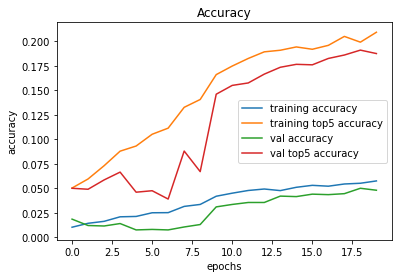

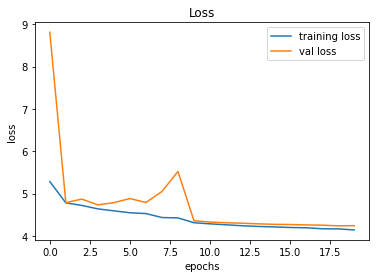

In [ ]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['top5_acc'], label='training top5 accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.plot(history.history['val_top5_acc'], label='val top5 accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [ ]:
y_predict = model7.predict(x_val)
y_pred = []
y_roc_auc=[]
for val in y_predict:
    y_pred.append(np.argmax(val))
    y_roc_auc.append(val)
cm = metrics.confusion_matrix(np.argmax(y_val,axis=1),y_pred)
print(cm)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
cr=metrics.classification_report(np.argmax(y_val,axis=1),y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.00      0.00      0.00        23
           2       0.00      0.00      0.00        21
           3       0.01      0.07      0.02        15
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        20
           6       0.00      0.00      0.00        18
           7       0.03      0.33      0.06        15
           8       0.00      0.00      0.00        13
           9       0.00      0.00      0.00        22
          10       0.00      0.00      0.00        22
          11       0.04      0.17      0.07        23
          12       0.00      0.00      0.00        12
          13       0.07      0.45      0.12        11
          14       0.00      0.00      0.00        19
          15       0.00      0.00      0.00        18
          16       0.00      0.00      0.00        14
          17       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print ('ROC-AUC Score: ', metrics.roc_auc_score(y_val,y_roc_auc,average='weighted',multi_class='ovo'))

ROC-AUC Score:  0.7714604172548798


Actual Dog Breed: ['labrador_retriever']
Predicted Dog Breed:  ['maltese_dog']


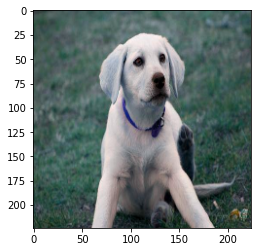

In [ ]:
plt.imshow(x_val[10])
print('Actual Dog Breed:',encoder.inverse_transform([np.argmax(y_val[10])]))
print('Predicted Dog Breed: ',encoder.inverse_transform([y_pred[10]]))	

## Verifying with a Mobilenet Model pre-trained on dogs dataset

In [33]:
# Setup input shape according to the pretrained-model input shape
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channel ass

# Setup output shape of the model
OUTPUT_SHAPE = 120 # number of unique labels

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [34]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)
  # Setup the model layers using sequential mode.
  model = tf.keras.Sequential([
                               hub.KerasLayer(MODEL_URL), # Layer 1 (the pre-trained model )
                               tf.keras.layers.Dense(units=512,activation="relu"), # Layer 2 (output layer)
                               tf.keras.layers.Dense(units=OUTPUT_SHAPE,activation="softmax") # Layer 2 (output layer)
                               ])
  # Compile the model
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',top5_acc])
  # Build the model
  model.build(INPUT_SHAPE)
  return model

In [ ]:
# Create a model and check its details
model8 = create_model()
model8.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense_9 (Dense)              (None, 512)               513024    
_________________________________________________________________
dense_10 (Dense)             (None, 120)               61560     
Total params: 6,007,297
Trainable params: 574,584
Non-trainable params: 5,432,713
_________________________________________________________________


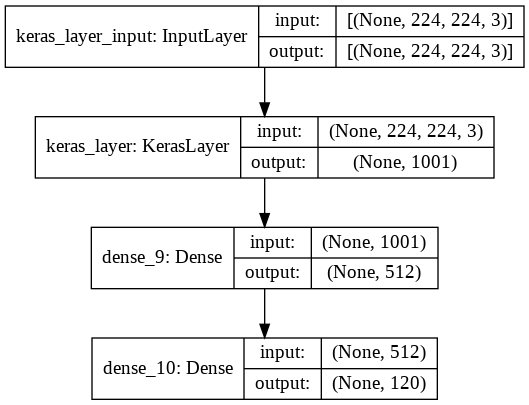

In [ ]:
tf.keras.utils.plot_model(model8, show_shapes=True, show_layer_names=True)

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
history = model8.fit(x_train,np.asarray(y_train),
                     validation_data=(x_val,np.asarray(y_val)),
                     epochs=EPOCHS,
                     batch_size=BATCH,
                     callbacks = [model_checkpoint,model_lr],
                     verbose=1)

Epoch 1/20
250/250 [==============================] - 20s 66ms/step - loss: 2.5456 - accuracy: 0.4121 - top5_acc: 0.6676 - val_loss: 1.1797 - val_accuracy: 0.6605 - val_top5_acc: 0.9230

Epoch 00001: val_accuracy improved from 0.05000 to 0.66050, saving model to dogbreed_cnn.h5
Epoch 2/20
250/250 [==============================] - 16s 63ms/step - loss: 0.5472 - accuracy: 0.8348 - top5_acc: 0.9804 - val_loss: 1.1545 - val_accuracy: 0.6720 - val_top5_acc: 0.9250

Epoch 00002: val_accuracy improved from 0.66050 to 0.67200, saving model to dogbreed_cnn.h5
Epoch 3/20
250/250 [==============================] - 16s 63ms/step - loss: 0.2377 - accuracy: 0.9313 - top5_acc: 0.9992 - val_loss: 1.1875 - val_accuracy: 0.6810 - val_top5_acc: 0.9275

Epoch 00003: val_accuracy improved from 0.67200 to 0.68100, saving model to dogbreed_cnn.h5
Epoch 4/20
250/250 [==============================] - 16s 63ms/step - loss: 0.1038 - accuracy: 0.9727 - top5_acc: 0.9997 - val_loss: 1.2369 - val_accuracy: 0.6845 

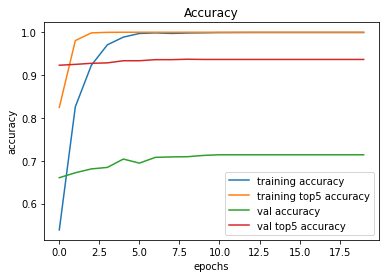

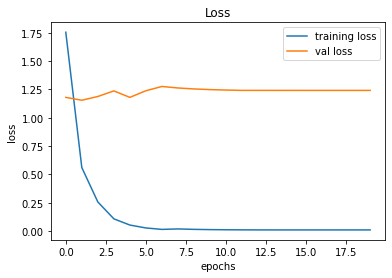

In [ ]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['top5_acc'], label='training top5 accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.plot(history.history['val_top5_acc'], label='val top5 accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [ ]:
y_predict = model8.predict(x_val)
y_pred = []
y_top5=[]
y_roc_auc=[]
for val in y_predict:
    y_pred.append(np.argmax(val))
    y_top5.append(np.argsort(val)[-5:])
    y_roc_auc.append(val)
cm = metrics.confusion_matrix(np.argmax(y_val,axis=1),y_pred)
print(cm)

[[14  0  0 ...  0  0  0]
 [ 0 19  0 ...  0  0  0]
 [ 0  0 20 ...  0  0  0]
 ...
 [ 0  0  0 ... 10  0  0]
 [ 0  0  0 ...  0 11  0]
 [ 0  0  0 ...  0  0 10]]


In [ ]:
cr=metrics.classification_report(np.argmax(y_val,axis=1),y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.93      0.88      0.90        16
           1       0.79      0.83      0.81        23
           2       1.00      0.95      0.98        21
           3       0.56      0.60      0.58        15
           4       0.33      0.30      0.32        10
           5       0.64      0.45      0.53        20
           6       0.69      0.61      0.65        18
           7       0.58      0.73      0.65        15
           8       0.77      0.77      0.77        13
           9       0.68      0.59      0.63        22
          10       0.95      0.91      0.93        22
          11       0.73      0.83      0.78        23
          12       0.55      0.50      0.52        12
          13       0.83      0.91      0.87        11
          14       0.68      0.68      0.68        19
          15       0.83      0.83      0.83        18
          16       0.54      0.50      0.52        14
          17       0.94    

In [ ]:
print ('ROC-AUC Score: ', metrics.roc_auc_score(y_val,y_roc_auc,average='weighted',multi_class='ovo'))

ROC-AUC Score:  0.993629743305634


Actual Dog Breed:  ['kelpie']
Predicted Dog Breed:  ['kelpie']


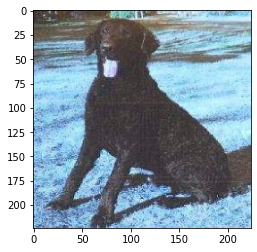

In [ ]:
plt.imshow(x_val[20])
print('Actual Dog Breed: ',encoder.inverse_transform([np.argmax(y_val[42])]))
print('Predicted Dog Breed: ',encoder.inverse_transform([y_pred[42]]))

In [ ]:
for i in range(len(y_val)):
  print('Actual Value: ',encoder.inverse_transform([np.argmax(y_val[i])]))
  print('Predicted Top-5 Breeds: ',encoder.inverse_transform(y_top5[i]))

Streaming output truncated to the last 5000 lines.
 'german_short-haired_pointer' 'basset']
Actual Value:  ['english_foxhound']
Predicted Top-5 Breeds:  ['vizsla' 'whippet' 'great_dane' 'basset' 'walker_hound']
Actual Value:  ['norfolk_terrier']
Predicted Top-5 Breeds:  ['miniature_schnauzer' 'silky_terrier' 'australian_terrier'
 'yorkshire_terrier' 'norfolk_terrier']
Actual Value:  ['old_english_sheepdog']
Predicted Top-5 Breeds:  ['soft-coated_wheaten_terrier' 'lakeland_terrier' 'kuvasz'
 'sealyham_terrier' 'old_english_sheepdog']
Actual Value:  ['collie']
Predicted Top-5 Breeds:  ['shetland_sheepdog' 'irish_wolfhound' 'borzoi' 'border_collie' 'collie']
Actual Value:  ['tibetan_terrier']
Predicted Top-5 Breeds:  ['pekinese' 'japanese_spaniel' 'lhasa' 'tibetan_terrier' 'shih-tzu']
Actual Value:  ['borzoi']
Predicted Top-5 Breeds:  ['golden_retriever' 'english_setter' 'borzoi' 'afghan_hound' 'saluki']
Actual Value:  ['gordon_setter']
Predicted Top-5 Breeds:  ['newfoundland' 'bloodhound

### Adding ImageAugmentation to see if there is any performance improvement or any resolution to the over-fitting problem

In [35]:
#from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                #rescale=1./255,
                                                                rotation_range=30,
                                                                shear_range=0.2,
                                                                zoom_range=0.2,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                fill_mode='nearest')
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

In [36]:
training_data = train_datagen.flow(x_train,y=np.asarray(y_train),batch_size=BATCH)
testing_data = test_datagen.flow(x_val,y=np.asarray(y_val),batch_size=BATCH)

In [37]:
tf.keras.backend.clear_session()

In [38]:
# Create a model and check its details
model9 = create_model()
model9.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 512)               513024    
_________________________________________________________________
dense_1 (Dense)              (None, 120)               61560     
Total params: 6,007,297
Trainable params: 574,584
Non-trainable params: 5,432,713
_________________________________________________________________


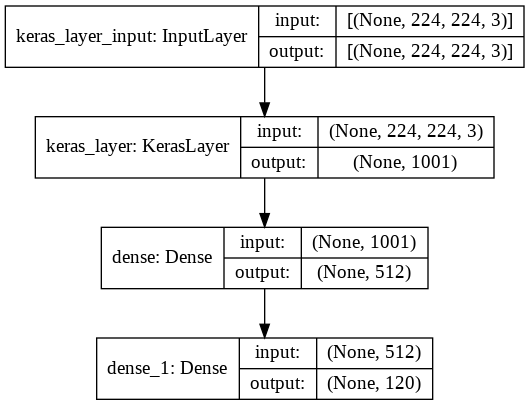

In [ ]:
tf.keras.utils.plot_model(model9, show_shapes=True, show_layer_names=True)

In [39]:
history = model9.fit(training_data,
                     epochs=EPOCHS,
                     steps_per_epoch= 8000//BATCH,  #Number of training images//batch_size
                     validation_data=testing_data,
                     validation_steps = 2000//BATCH, #Number of test images//batch_size,
                     callbacks = [model_checkpoint,model_lr],
                     verbose=1)

Epoch 1/20
250/250 [==============================] - 107s 407ms/step - loss: 3.8010 - accuracy: 0.1787 - top5_acc: 0.4042 - val_loss: 1.3669 - val_accuracy: 0.6028 - val_top5_acc: 0.8962

Epoch 00001: val_accuracy improved from 0.00756 to 0.60282, saving model to dogbreed_cnn.h5
Epoch 2/20
250/250 [==============================] - 100s 400ms/step - loss: 2.0126 - accuracy: 0.4710 - top5_acc: 0.7712 - val_loss: 1.3128 - val_accuracy: 0.6260 - val_top5_acc: 0.9098

Epoch 00002: val_accuracy improved from 0.60282 to 0.62601, saving model to dogbreed_cnn.h5
Epoch 3/20
250/250 [==============================] - 99s 395ms/step - loss: 1.7941 - accuracy: 0.5061 - top5_acc: 0.8176 - val_loss: 1.3082 - val_accuracy: 0.6361 - val_top5_acc: 0.9128

Epoch 00003: val_accuracy improved from 0.62601 to 0.63609, saving model to dogbreed_cnn.h5
Epoch 4/20
250/250 [==============================] - 99s 394ms/step - loss: 1.6091 - accuracy: 0.5553 - top5_acc: 0.8502 - val_loss: 1.2728 - val_accuracy: 0

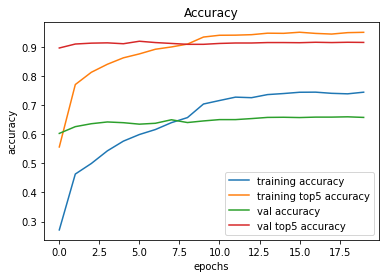

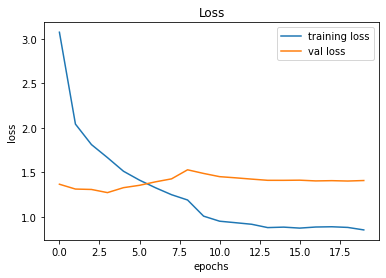

In [40]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['top5_acc'], label='training top5 accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.plot(history.history['val_top5_acc'], label='val top5 accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [41]:
y_predict = model9.predict(x_val)
y_pred = []
y_roc_auc=[]
y_top5=[]
for val in y_predict:
    y_pred.append(np.argmax(val))
    y_roc_auc.append(val)
    y_top5.append(np.argsort(val)[-5:])
cm = metrics.confusion_matrix(np.argmax(y_val,axis=1),y_pred)
print(cm)

[[12  0  0 ...  0  0  0]
 [ 0 19  0 ...  0  0  0]
 [ 0  0 18 ...  0  0  0]
 ...
 [ 0  0  0 ... 10  0  0]
 [ 0  0  0 ...  0 10  0]
 [ 0  0  0 ...  0  0 11]]


In [42]:
cr=metrics.classification_report(np.argmax(y_val,axis=1),y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.92      0.75      0.83        16
           1       0.76      0.83      0.79        23
           2       0.90      0.86      0.88        21
           3       0.88      0.47      0.61        15
           4       0.32      0.60      0.41        10
           5       0.46      0.60      0.52        20
           6       0.91      0.56      0.69        18
           7       0.57      0.53      0.55        15
           8       0.50      0.62      0.55        13
           9       0.59      0.45      0.51        22
          10       0.94      0.73      0.82        22
          11       0.74      0.87      0.80        23
          12       0.31      0.33      0.32        12
          13       0.90      0.82      0.86        11
          14       0.54      0.79      0.64        19
          15       0.60      0.50      0.55        18
          16       0.70      0.50      0.58        14
          17       1.00    

In [43]:
print ('ROC-AUC Score: ', metrics.roc_auc_score(y_val,y_roc_auc,average='weighted',multi_class='ovo'))

ROC-AUC Score:  0.9911365450346612


Actual Dog Breed: ['labrador_retriever']
Predicted Dog Breed:  ['labrador_retriever']


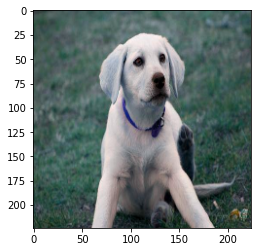

In [44]:
plt.imshow(x_val[10])
print('Actual Dog Breed:',encoder.inverse_transform([np.argmax(y_val[10])]))
print('Predicted Dog Breed: ',encoder.inverse_transform([y_pred[10]]))

In [45]:
for i in range(len(y_val)):
  print('Actual Value: ',encoder.inverse_transform([np.argmax(y_val[i])]))
  print('Predicted Top-5 Breeds: ',encoder.inverse_transform(y_top5[i]))

Streaming output truncated to the last 5000 lines.
 'bernese_mountain_dog']
Actual Value:  ['golden_retriever']
Predicted Top-5 Breeds:  ['irish_wolfhound' 'bloodhound' 'weimaraner' 'saluki' 'golden_retriever']
Actual Value:  ['bloodhound']
Predicted Top-5 Breeds:  ['bluetick' 'pug' 'labrador_retriever' 'black-and-tan_coonhound'
 'brabancon_griffon']
Actual Value:  ['briard']
Predicted Top-5 Breeds:  ['tibetan_terrier' 'collie' 'irish_wolfhound' 'briard' 'afghan_hound']
Actual Value:  ['welsh_springer_spaniel']
Predicted Top-5 Breeds:  ['english_springer' 'irish_setter' 'welsh_springer_spaniel'
 'cocker_spaniel' 'english_setter']
Actual Value:  ['doberman']
Predicted Top-5 Breeds:  ['rottweiler' 'kelpie' 'black-and-tan_coonhound' 'miniature_pinscher'
 'doberman']
Actual Value:  ['australian_terrier']
Predicted Top-5 Breeds:  ['yorkshire_terrier' 'dandie_dinmont' 'norwich_terrier' 'silky_terrier'
 'australian_terrier']
Actual Value:  ['silky_terrier']
Predicted Top-5 Breeds:  ['standard

## Increasing the size of training data to 9k images by changing the train-test split to 90:10, but with the same pre-trained Mobilenet model as earlier

In [16]:
IMG_SIZE=224
channels=3
EPOCHS=20
BATCH=32
NUM_IMAGES = 10000

In [17]:
x_features=[]
label=[]

for f, img in tqdm(labels.values): #f for image id, img for dog breed
  #Using cv2.imread results in BGR images, instead of the standard RGB as below
  train_img = cv2.imread('./train/{}.jpg'.format(f),1) #0 for grayscale & 1 for color (o/p is bgr)
  train_img_resize = cv2.resize(train_img, (IMG_SIZE,IMG_SIZE))
  x_features.append(train_img_resize)
  label.append(img)

100%|██████████| 10222/10222 [00:35<00:00, 291.98it/s]


In [18]:
encoder = LabelEncoder()
label = encoder.fit_transform(label)
y_label=tf.keras.utils.to_categorical(label, num_classes=120, dtype='int')#, 120)

In [19]:
# Set number of images to use for experimenting
x_train,x_val,y_train,y_val=train_test_split(x_features[:NUM_IMAGES],
                                             y_label[:NUM_IMAGES],
                                             test_size=0.1,
                                             random_state=42)

In [20]:
x_train = np.array(x_train,np.float32)/255.0  #Division by 255. for normalisation
print(x_train.shape)

x_val = np.array(x_val,np.float32)/255.0  #Division by 255. for normalisation
print(x_val.shape)

(9000, 224, 224, 3)
(1000, 224, 224, 3)


In [21]:
tf.keras.backend.clear_session()

In [22]:
# Setup input shape according to the pretrained-model input shape
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channel ass

# Setup output shape of the model
OUTPUT_SHAPE = 120 # number of unique labels

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [23]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)
  # Setup the model layers using sequential mode.
  model = tf.keras.Sequential([
                               hub.KerasLayer(MODEL_URL), # Layer 1 (the pre-trained model )
                               tf.keras.layers.Dense(units=512,activation="relu"), # Layer 2 (output layer)
                               tf.keras.layers.Dense(units=OUTPUT_SHAPE,activation="softmax") # Layer 2 (output layer)
                               ])
  # Compile the model
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',top5_acc])
  # Build the model
  model.build(INPUT_SHAPE)
  return model

In [24]:
# Create a model and check its details
model10 = create_model()
model10.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 512)               513024    
_________________________________________________________________
dense_1 (Dense)              (None, 120)               61560     
Total params: 6,007,297
Trainable params: 574,584
Non-trainable params: 5,432,713
_________________________________________________________________


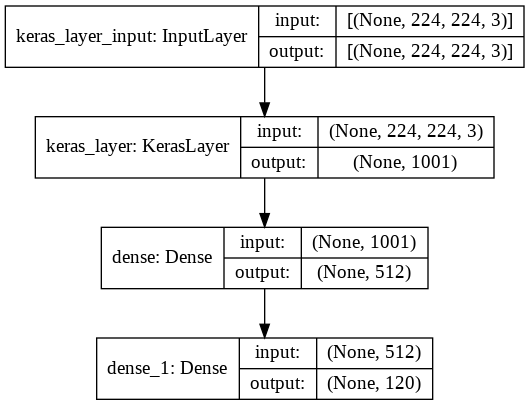

In [25]:
tf.keras.utils.plot_model(model10, show_shapes=True, show_layer_names=True)

In [26]:
history = model10.fit(x_train,np.asarray(y_train),
                     validation_data=(x_val,np.asarray(y_val)),
                     epochs=EPOCHS,
                     batch_size=BATCH,
                     callbacks = [model_checkpoint,model_lr],
                     verbose=1)

Epoch 1/20
282/282 [==============================] - 57s 129ms/step - loss: 2.4635 - accuracy: 0.4261 - top5_acc: 0.6876 - val_loss: 1.1330 - val_accuracy: 0.6670 - val_top5_acc: 0.9130

Epoch 00001: val_accuracy improved from -inf to 0.66700, saving model to dogbreed_cnn.h5
Epoch 2/20
282/282 [==============================] - 34s 122ms/step - loss: 0.5651 - accuracy: 0.8326 - top5_acc: 0.9824 - val_loss: 1.1984 - val_accuracy: 0.6450 - val_top5_acc: 0.9270

Epoch 00002: val_accuracy did not improve from 0.66700
Epoch 3/20
282/282 [==============================] - 34s 122ms/step - loss: 0.2554 - accuracy: 0.9237 - top5_acc: 0.9988 - val_loss: 1.2292 - val_accuracy: 0.6620 - val_top5_acc: 0.9210

Epoch 00003: val_accuracy did not improve from 0.66700
Epoch 4/20
282/282 [==============================] - 34s 122ms/step - loss: 0.1271 - accuracy: 0.9710 - top5_acc: 0.9999 - val_loss: 1.2753 - val_accuracy: 0.6750 - val_top5_acc: 0.9270

Epoch 00004: val_accuracy improved from 0.66700 t

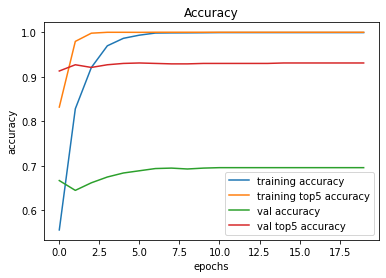

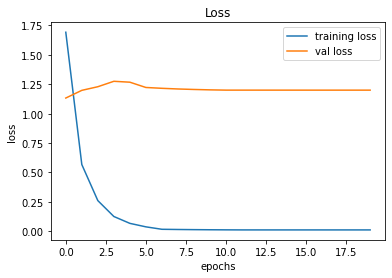

In [27]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['top5_acc'], label='training top5 accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.plot(history.history['val_top5_acc'], label='val top5 accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [28]:
y_predict = model10.predict(x_val)
y_pred = []
y_roc_auc=[]
y_top5=[]
for val in y_predict:
    y_pred.append(np.argmax(val))
    y_roc_auc.append(val)
    y_top5.append(np.argsort(val)[-5:])
cm = metrics.confusion_matrix(np.argmax(y_val,axis=1),y_pred)
print(cm)

[[ 8  0  0 ...  0  0  0]
 [ 0  8  0 ...  0  0  0]
 [ 0  0 13 ...  0  0  0]
 ...
 [ 0  0  0 ...  2  0  0]
 [ 0  0  0 ...  0  6  0]
 [ 0  0  0 ...  0  0  6]]


In [29]:
cr=metrics.classification_report(np.argmax(y_val,axis=1),y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       0.73      0.89      0.80         9
           2       1.00      0.93      0.96        14
           3       0.38      0.50      0.43         6
           4       0.20      0.17      0.18         6
           5       0.56      0.56      0.56         9
           6       0.67      0.80      0.73        10
           7       0.67      0.86      0.75         7
           8       0.75      1.00      0.86         6
           9       0.71      0.62      0.67         8
          10       1.00      1.00      1.00        11
          11       0.75      0.92      0.83        13
          12       0.40      0.50      0.44         4
          13       0.60      1.00      0.75         6
          14       0.71      0.71      0.71         7
          15       1.00      0.70      0.82        10
          16       0.82      0.75      0.78        12
          17       0.82    

In [30]:
print ('ROC-AUC Score: ', metrics.roc_auc_score(y_val,y_roc_auc,average='weighted',multi_class='ovo'))

ROC-AUC Score:  0.9941389570209278


Actual Dog Breed: ['labrador_retriever']
Predicted Dog Breed:  ['labrador_retriever']


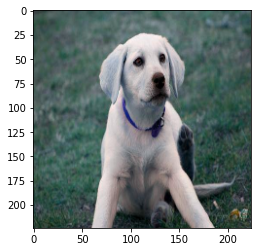

In [31]:
plt.imshow(x_val[10])
print('Actual Dog Breed:',encoder.inverse_transform([np.argmax(y_val[10])]))
print('Predicted Dog Breed: ',encoder.inverse_transform([y_pred[10]]))

In [32]:
for i in range(len(y_val)):
  print('Actual Value: ',encoder.inverse_transform([np.argmax(y_val[i])]))
  print('Predicted Top-5 Breeds: ',encoder.inverse_transform(y_top5[i]))

Actual Value:  ['entlebucher']
Predicted Top-5 Breeds:  ['walker_hound' 'english_foxhound' 'beagle' 'appenzeller' 'entlebucher']
Actual Value:  ['pomeranian']
Predicted Top-5 Breeds:  ['samoyed' 'shetland_sheepdog' 'pekinese' 'japanese_spaniel' 'pomeranian']
Actual Value:  ['norfolk_terrier']
Predicted Top-5 Breeds:  ['norfolk_terrier' 'cairn' 'maltese_dog' 'norwich_terrier'
 'west_highland_white_terrier']
Actual Value:  ['schipperke']
Predicted Top-5 Breeds:  ['chihuahua' 'miniature_pinscher' 'staffordshire_bullterrier' 'kelpie'
 'schipperke']
Actual Value:  ['lhasa']
Predicted Top-5 Breeds:  ['briard' 'silky_terrier' 'tibetan_terrier' 'shih-tzu' 'lhasa']
Actual Value:  ['pembroke']
Predicted Top-5 Breeds:  ['appenzeller' 'beagle' 'dingo' 'cardigan' 'pembroke']
Actual Value:  ['great_pyrenees']
Predicted Top-5 Breeds:  ['old_english_sheepdog' 'tibetan_mastiff' 'newfoundland' 'chow'
 'great_pyrenees']
Actual Value:  ['golden_retriever']
Predicted Top-5 Breeds:  ['chesapeake_bay_retriev

### Adding ImageAugmentation as earlier to reduce Over-Fitting

In [33]:
tf.keras.backend.clear_session()

In [34]:
#from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                #rescale=1./255,
                                                                rotation_range=30,
                                                                shear_range=0.2,
                                                                zoom_range=0.2,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                fill_mode='nearest')
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

In [35]:
training_data = train_datagen.flow(x_train,y=np.asarray(y_train),batch_size=BATCH)
testing_data = test_datagen.flow(x_val,y=np.asarray(y_val),batch_size=BATCH)

In [36]:
# Create a model and check its details
model11 = create_model()
model11.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 512)               513024    
_________________________________________________________________
dense_1 (Dense)              (None, 120)               61560     
Total params: 6,007,297
Trainable params: 574,584
Non-trainable params: 5,432,713
_________________________________________________________________


In [37]:
history = model11.fit(training_data,
                     epochs=EPOCHS,
                     steps_per_epoch= 9000//BATCH,  #Number of training images//batch_size
                     validation_data=testing_data,
                     validation_steps = 1000//BATCH, #Number of test images//batch_size,
                     callbacks = [model_checkpoint,model_lr],
                     verbose=1)

Epoch 1/20
281/281 [==============================] - 118s 404ms/step - loss: 3.6118 - accuracy: 0.2082 - top5_acc: 0.4386 - val_loss: 1.4125 - val_accuracy: 0.5696 - val_top5_acc: 0.9002

Epoch 00001: val_accuracy did not improve from 0.69600
Epoch 2/20
281/281 [==============================] - 113s 401ms/step - loss: 2.0064 - accuracy: 0.4583 - top5_acc: 0.7792 - val_loss: 1.3834 - val_accuracy: 0.6069 - val_top5_acc: 0.8982

Epoch 00002: val_accuracy did not improve from 0.69600
Epoch 3/20
281/281 [==============================] - 112s 397ms/step - loss: 1.7796 - accuracy: 0.5162 - top5_acc: 0.8130 - val_loss: 1.2740 - val_accuracy: 0.6391 - val_top5_acc: 0.9143

Epoch 00003: val_accuracy did not improve from 0.69600
Epoch 4/20
281/281 [==============================] - 111s 395ms/step - loss: 1.5696 - accuracy: 0.5577 - top5_acc: 0.8526 - val_loss: 1.3407 - val_accuracy: 0.6260 - val_top5_acc: 0.9123

Epoch 00004: val_accuracy did not improve from 0.69600
Epoch 5/20
281/281 [====

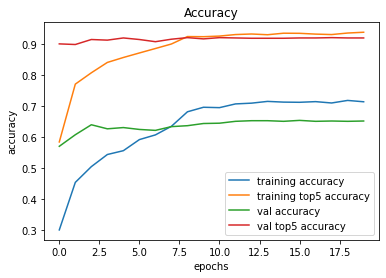

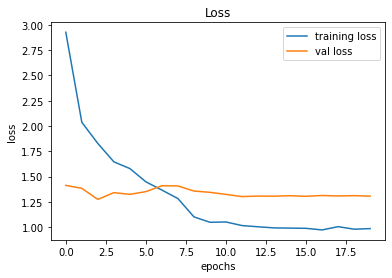

In [38]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['top5_acc'], label='training top5 accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.plot(history.history['val_top5_acc'], label='val top5 accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [39]:
y_predict = model11.predict(x_val)
y_pred = []
y_roc_auc=[]
y_top5=[]
for val in y_predict:
    y_pred.append(np.argmax(val))
    y_roc_auc.append(val)
    y_top5.append(np.argsort(val)[-5:])
cm = metrics.confusion_matrix(np.argmax(y_val,axis=1),y_pred)
print(cm)

[[ 7  0  0 ...  0  0  0]
 [ 0  8  0 ...  0  0  0]
 [ 0  0 13 ...  0  0  0]
 ...
 [ 0  0  0 ...  2  0  0]
 [ 0  0  0 ...  0  5  0]
 [ 0  0  0 ...  0  0  4]]


In [40]:
cr=metrics.classification_report(np.argmax(y_val,axis=1),y_pred)
print(cr)

              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.62      0.89      0.73         9
           2       1.00      0.93      0.96        14
           3       0.60      0.50      0.55         6
           4       0.60      0.50      0.55         6
           5       0.67      0.22      0.33         9
           6       0.71      0.50      0.59        10
           7       0.55      0.86      0.67         7
           8       0.75      0.50      0.60         6
           9       0.57      1.00      0.73         8
          10       1.00      0.91      0.95        11
          11       0.89      0.62      0.73        13
          12       0.29      0.50      0.36         4
          13       0.67      0.67      0.67         6
          14       0.42      0.71      0.53         7
          15       0.80      0.80      0.80        10
          16       0.53      0.75      0.62        12
          17       0.91    

In [41]:
print ('ROC-AUC Score: ', metrics.roc_auc_score(y_val,y_roc_auc,average='weighted',multi_class='ovo'))

ROC-AUC Score:  0.9919507192990009


Actual Dog Breed: ['labrador_retriever']
Predicted Dog Breed:  ['labrador_retriever']


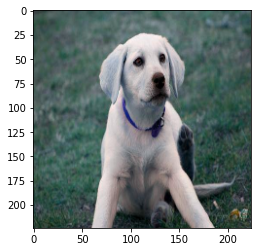

In [42]:
plt.imshow(x_val[10])
print('Actual Dog Breed:',encoder.inverse_transform([np.argmax(y_val[10])]))
print('Predicted Dog Breed: ',encoder.inverse_transform([y_pred[10]]))	

In [43]:
for i in range(len(y_val)):
  print('Actual Value: ',encoder.inverse_transform([np.argmax(y_val[i])]))
  print('Predicted Top-5 Breeds: ',encoder.inverse_transform(y_top5[i]))

Actual Value:  ['entlebucher']
Predicted Top-5 Breeds:  ['appenzeller' 'walker_hound' 'beagle' 'english_foxhound' 'entlebucher']
Actual Value:  ['pomeranian']
Predicted Top-5 Breeds:  ['samoyed' 'chow' 'pekinese' 'shetland_sheepdog' 'pomeranian']
Actual Value:  ['norfolk_terrier']
Predicted Top-5 Breeds:  ['australian_terrier' 'norfolk_terrier' 'norwich_terrier'
 'west_highland_white_terrier' 'cairn']
Actual Value:  ['schipperke']
Predicted Top-5 Breeds:  ['staffordshire_bullterrier' 'miniature_pinscher' 'groenendael' 'kelpie'
 'schipperke']
Actual Value:  ['lhasa']
Predicted Top-5 Breeds:  ['pekinese' 'briard' 'tibetan_terrier' 'shih-tzu' 'lhasa']
Actual Value:  ['pembroke']
Predicted Top-5 Breeds:  ['chihuahua' 'eskimo_dog' 'beagle' 'cardigan' 'pembroke']
Actual Value:  ['great_pyrenees']
Predicted Top-5 Breeds:  ['tibetan_mastiff' 'chow' 'newfoundland' 'clumber' 'great_pyrenees']
Actual Value:  ['golden_retriever']
Predicted Top-5 Breeds:  ['saluki' 'great_pyrenees' 'labrador_retrie

## Testing our model on a randomly downloaded image from the internet

(224, 224, 3)
Predicted Dog Breed:  ['german_shepherd']


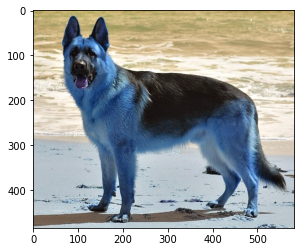

In [44]:
rand_img = cv2.imread('/content/drive/My Drive/PGP-AIML/Capstone/Using CNN to classify Dog Breeds based on images/German_Shepherd_-_DSC_0346_(10096362833).jpg'.format(f),1) #0 for grayscale & 1 for color (o/p is bgr)
rand_img_resize = cv2.resize(rand_img, (IMG_SIZE,IMG_SIZE))

rand_img_arr = np.array(rand_img_resize,np.float32)/255.0  #Division by 255. for normalisation
print(rand_img_arr.shape)

img_batch = rand_img_arr.reshape(1,IMG_SIZE,IMG_SIZE,channels) #Creating a batch of one-image
rand_img_pred = model11.predict(img_batch,batch_size=1)
pred=np.argmax(rand_img_pred)

plt.imshow(rand_img)
print('Predicted Dog Breed: ',encoder.inverse_transform([pred]))